In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import cm
matplotlib.rcParams['figure.figsize'] = (10, 5)
import pandas as pd
import math as m
from sklearn.metrics import f1_score, mean_absolute_error, mean_squared_error, accuracy_score

from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor  # Use XGBClassifier for classification tasks

In [2]:
data = "processed_dataset.csv"

DATA17 = "data/raw/Onsite-MetMast-SCADA-data-2017.xlsx"
DATAScada17 = "data/raw/Wind-Turbine-SCADA-signals-2017_0.xlsx"

data17 = pd.read_excel(DATA17, engine='openpyxl')
datascada17= pd.read_excel(DATAScada17, engine="openpyxl")

merged_df17 = pd.merge(datascada17, data17, on="Timestamp", how="inner")

In [3]:
#merged_df17.to_csv()

In [4]:
merged_df = pd.read_csv(data)

the csv file is a preprocessed file, which was processed using rules from analysis of the power production

scada data from 2017 needs to be preprocessed as well:
- t07 turbine should only be evaluated (see below)

In [5]:
#t07 is selected
merged_df17 = merged_df17[merged_df17["Turbine_ID"] == "T07"]

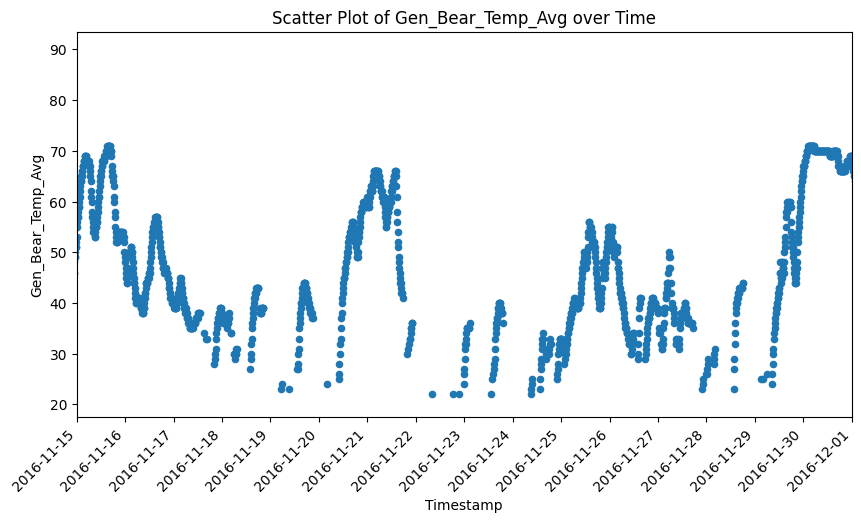

In [6]:
# plotting some data to look for outliers and anomalties in the data itself. Visualize the data
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

#for i in merged_df:
merged_df['Timestamp'] = pd.to_datetime(merged_df['Timestamp'])

ax = merged_df.plot.scatter(x="Timestamp", y="Gen_Bear_Temp_Avg")

# Customize the format of the timestamp on the x-axis
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# Optionally, set the locator for more control over tick placement
ax.xaxis.set_major_locator(mdates.DayLocator())  # You can adjust the locator based on your data frequency

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')
#Define interval for data
plt.xlim(pd.Timestamp('2016-11-15'), pd.Timestamp('2016-12-01'))

# Add labels and title
plt.xlabel('Timestamp')
plt.ylabel('Gen_Bear_Temp_Avg')
plt.title('Scatter Plot of Gen_Bear_Temp_Avg over Time')

# Show the plot
plt.show()


In [7]:
import pandas as pd
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, accuracy_score

# Step 2: Specify the feature columns and the target variable
feature_columns = ["Gen_Phase1_Temp_Avg", "Gen_RPM_Avg", "Avg_Windspeed1", "Nac_Temp_Avg", "Avg_Humidity"]  # Features
target_column = 'Gen_Bear_Temp_Avg'  # Target variable

# Step 3: Prepare the training data from merged_df
X_train = merged_df[feature_columns]  # Feature set for training
y_train = merged_df[target_column]   # Target variable for training

# Step 4: Prepare the prediction data from merged_df17
X_test = merged_df17[feature_columns]  # Feature set for predictions

# Step 5: Initialize the XGBoost model
model = XGBRegressor()  # Use XGBClassifier() if it's a classification task

# Step 6: Train the model
model.fit(X_train, y_train)

# Step 7: Make predictions on the merged_df17 dataset
predictions = model.predict(X_test)

# Step 8: Evaluate the model on merged_df (Optional)
"""# This evaluation is only for the training dataset, not merged_df17
if isinstance(y_train, pd.Series) and y_train.nunique() <= 2:
    # If the target variable has two unique values, treat it as a classification problem
    train_predictions = model.predict(X_train)
    accuracy = accuracy_score(y_train, train_predictions.round())
    print(f'Accuracy on Training Data: {accuracy:.2f}')
else:
    # If it's a regression problem, calculate the mean squared error
    train_predictions = model.predict(X_train)
    mse = mean_squared_error(y_train, train_predictions)
    print(f'Mean Squared Error on Training Data: {mse:.2f}')"""

# Step 9: Store predictions in merged_df17
merged_df17["xgboost_pred_2017"] = predictions


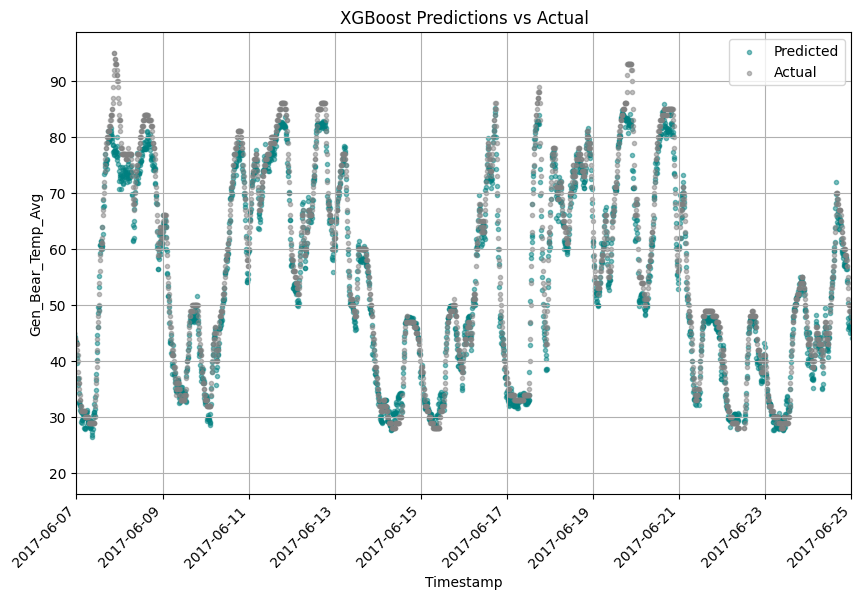

In [8]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure Timestamp column is in datetime format
merged_df17["Timestamp"] = pd.to_datetime(merged_df17["Timestamp"])

# Sort merged_df17 by "Timestamp" for better visualization
merged_df_filtered17_sorted = merged_df17.sort_values(by="Timestamp")

plt.figure(figsize=(10, 6))

# Scatter plot for predicted values
plt.scatter(
    merged_df_filtered17_sorted["Timestamp"],  # Sorted timestamps
    merged_df_filtered17_sorted["xgboost_pred_2017"],  # Predictions stored in 'cp_xgboost'
    c='teal', alpha=0.5, label='Predicted', marker="."
)

# Scatter plot for actual values (y_test)
plt.scatter(
    merged_df_filtered17_sorted["Timestamp"],  # Sorted timestamps
    merged_df_filtered17_sorted[target_column],  # Actual target values
    c='grey', alpha=0.5, label='Actual', marker=".", 
)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Define interval for data (adjust as needed)
plt.xlim(pd.to_datetime('2017-06-07'), pd.to_datetime('2017-06-25'))

plt.title("XGBoost Predictions vs Actual")
plt.xlabel("Timestamp")
plt.ylabel(target_column)
plt.legend()  # Show legend to distinguish between predicted and actual values
plt.grid(True)
plt.show()


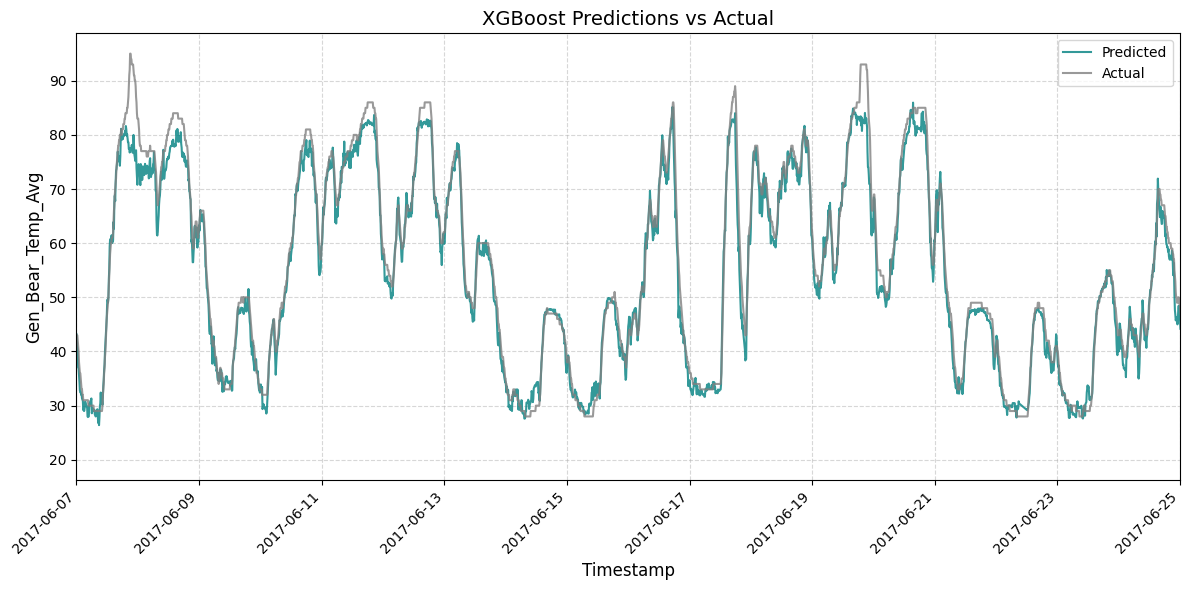

In [9]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure Timestamp column is in datetime format
merged_df17["Timestamp"] = pd.to_datetime(merged_df17["Timestamp"])

# Sort merged_df17 by "Timestamp" for better visualization
merged_df_filtered17_sorted = merged_df17.sort_values(by="Timestamp")

plt.figure(figsize=(12, 6))

# Line plot for predicted values
plt.plot(
    merged_df_filtered17_sorted["Timestamp"],  # Sorted timestamps
    merged_df_filtered17_sorted["xgboost_pred_2017"],  # Predictions
    color='teal', alpha=0.8, label='Predicted', linestyle='-', linewidth=1.5
)

# Line plot for actual values
plt.plot(
    merged_df_filtered17_sorted["Timestamp"],  # Sorted timestamps
    merged_df_filtered17_sorted[target_column],  # Actual target values
    color='grey', alpha=0.8, label='Actual', linestyle='-', linewidth=1.5
)

# Highlight x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Define interval for x-axis (adjust as needed)
plt.xlim(pd.to_datetime('2017-06-07'), pd.to_datetime('2017-06-25'))

# Title and labels
plt.title("XGBoost Predictions vs Actual", fontsize=14)
plt.xlabel("Timestamp", fontsize=12)
plt.ylabel(target_column, fontsize=12)

# Legend and grid for clarity
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()


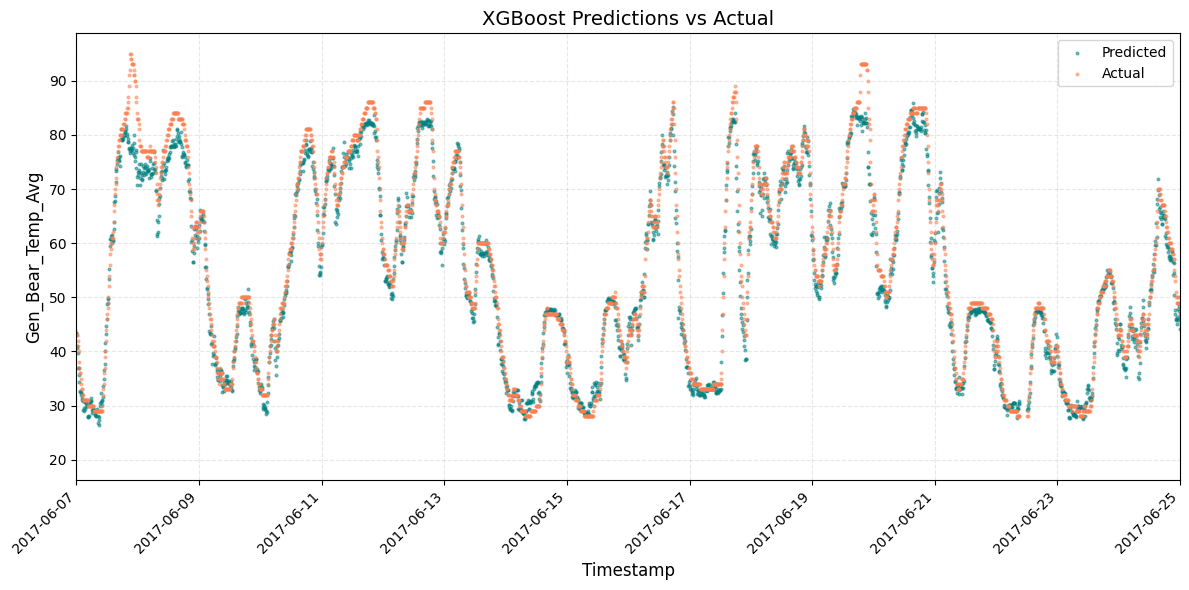

In [10]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure Timestamp column is in datetime format
merged_df17["Timestamp"] = pd.to_datetime(merged_df17["Timestamp"])

# Sort merged_df17 by "Timestamp" for better visualization
merged_df_filtered17_sorted = merged_df17.sort_values(by="Timestamp")

plt.figure(figsize=(12, 6))

# Scatter plot for predicted values
plt.scatter(
    merged_df_filtered17_sorted["Timestamp"],  # Sorted timestamps
    merged_df_filtered17_sorted["xgboost_pred_2017"],  # Predictions
    c='teal', alpha=0.5, label='Predicted', marker='.', s=15  # Adjusted size and transparency
)

# Scatter plot for actual values
plt.scatter(
    merged_df_filtered17_sorted["Timestamp"],  # Sorted timestamps
    merged_df_filtered17_sorted[target_column],  # Actual target values
    c='coral', alpha=0.5, label='Actual', marker='.', s=15  # Different marker and transparency
)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Define interval for x-axis (adjust as needed)
plt.xlim(pd.to_datetime('2017-06-07'), pd.to_datetime('2017-06-25'))

# Title and labels
plt.title("XGBoost Predictions vs Actual", fontsize=14)
plt.xlabel("Timestamp", fontsize=12)
plt.ylabel(target_column, fontsize=12)

# Legend and grid for clarity
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.3)  # Subtle grid

plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()


In [11]:
merged_df_filtered17_sorted

Turbine_ID                 Timestamp  Gen_RPM_Max  Gen_RPM_Min  \
87615        T07 2017-01-01 00:00:00+00:00       1513.4       1255.3   
37433        T07 2017-01-01 00:10:00+00:00       1485.4       1243.1   
54937        T07 2017-01-01 00:20:00+00:00       1505.3       1255.1   
87608        T07 2017-01-01 00:30:00+00:00       1486.6       1246.1   
19102        T07 2017-01-01 00:40:00+00:00       1381.6       1241.4   
...          ...                       ...          ...          ...   
729          T07 2017-12-31 23:10:00+00:00       1576.2       1253.8   
734          T07 2017-12-31 23:20:00+00:00       1577.7       1231.2   
29823        T07 2017-12-31 23:30:00+00:00       1282.8       1232.5   
738          T07 2017-12-31 23:40:00+00:00       1269.8       1230.8   
65839        T07 2017-12-31 23:50:00+00:00       1329.9       1193.0   

       Gen_RPM_Avg  Gen_RPM_Std  Gen_Bear_Temp_Avg  Gen_Phase1_Temp_Avg  \
87615       1336.5         47.6               36.0                   58   
37433       1307.9         34.7               36.0                   58   
54937       1325.9         41.4               36.0                   58   
87608       1322.4         44.7               36.0                   58   
19102       1292.4         31.1               36.0                   58   
...            ...          ...                ...                  ...   
729         1387.4         79.7               39.0                   64   
734         1343.0         87.5               39.0                   63   
29823       1250.7          8.5               38.0                   63   
738         1250.2          6.9               38.0                   62   
65839       1257.6         18.9               38.0                   61   

       Gen_Phase2_Temp_Avg  Gen_Phase3_Temp_Avg  ...  Anemometer2_Freq  \
87615                   58                   58  ...            0.0499   
37433                   58                   58  ...            0.0499   
54937                   58                   58  ...            0.0499   
87608                   58                   58  ...            0.0499   
19102                   58                   58  ...            0.0499   
...                    ...                  ...  ...               ...   
729                     64                   63  ...            0.0499   
734                     63                   63  ...            0.0499   
29823                   63                   62  ...            0.0499   
738                     62                   61  ...            0.0499   
65839                   61                   61  ...            0.0499   

       Anemometer2_Offset  Anemometer2_CorrGain  Anemometer2_CorrOffset  \
87615                0.24                     1                       0   
37433                0.24                     1                       0   
54937                0.24                     1                       0   
87608                0.24                     1                       0   
19102                0.24                     1                       0   
...                   ...                   ...                     ...   
729                  0.24                     1                       0   
734                  0.24                     1                       0   
29823                0.24                     1                       0   
738                  0.24                     1                       0   
65839                0.24                     1                       0   

       DistanceAirPress  AirRessureSensorZeroOffset  Anemometer1_Avg_Freq  \
87615                 0                         600                   156   
37433                 0                         600                   148   
54937                 0                         600                   151   
87608                 0                         600                   157   
19102                 0                         600              

In [12]:
merged_df_filtered17_sorted

Turbine_ID                 Timestamp  Gen_RPM_Max  Gen_RPM_Min  \
87615        T07 2017-01-01 00:00:00+00:00       1513.4       1255.3   
37433        T07 2017-01-01 00:10:00+00:00       1485.4       1243.1   
54937        T07 2017-01-01 00:20:00+00:00       1505.3       1255.1   
87608        T07 2017-01-01 00:30:00+00:00       1486.6       1246.1   
19102        T07 2017-01-01 00:40:00+00:00       1381.6       1241.4   
...          ...                       ...          ...          ...   
729          T07 2017-12-31 23:10:00+00:00       1576.2       1253.8   
734          T07 2017-12-31 23:20:00+00:00       1577.7       1231.2   
29823        T07 2017-12-31 23:30:00+00:00       1282.8       1232.5   
738          T07 2017-12-31 23:40:00+00:00       1269.8       1230.8   
65839        T07 2017-12-31 23:50:00+00:00       1329.9       1193.0   

       Gen_RPM_Avg  Gen_RPM_Std  Gen_Bear_Temp_Avg  Gen_Phase1_Temp_Avg  \
87615       1336.5         47.6               36.0                   58   
37433       1307.9         34.7               36.0                   58   
54937       1325.9         41.4               36.0                   58   
87608       1322.4         44.7               36.0                   58   
19102       1292.4         31.1               36.0                   58   
...            ...          ...                ...                  ...   
729         1387.4         79.7               39.0                   64   
734         1343.0         87.5               39.0                   63   
29823       1250.7          8.5               38.0                   63   
738         1250.2          6.9               38.0                   62   
65839       1257.6         18.9               38.0                   61   

       Gen_Phase2_Temp_Avg  Gen_Phase3_Temp_Avg  ...  Anemometer2_Freq  \
87615                   58                   58  ...            0.0499   
37433                   58                   58  ...            0.0499   
54937                   58                   58  ...            0.0499   
87608                   58                   58  ...            0.0499   
19102                   58                   58  ...            0.0499   
...                    ...                  ...  ...               ...   
729                     64                   63  ...            0.0499   
734                     63                   63  ...            0.0499   
29823                   63                   62  ...            0.0499   
738                     62                   61  ...            0.0499   
65839                   61                   61  ...            0.0499   

       Anemometer2_Offset  Anemometer2_CorrGain  Anemometer2_CorrOffset  \
87615                0.24                     1                       0   
37433                0.24                     1                       0   
54937                0.24                     1                       0   
87608                0.24                     1                       0   
19102                0.24                     1                       0   
...                   ...                   ...                     ...   
729                  0.24                     1                       0   
734                  0.24                     1                       0   
29823                0.24                     1                       0   
738                  0.24                     1                       0   
65839                0.24                     1                       0   

       DistanceAirPress  AirRessureSensorZeroOffset  Anemometer1_Avg_Freq  \
87615                 0                         600                   156   
37433                 0                         600                   148   
54937                 0                         600                   151   
87608                 0                         600                   157   
19102                 0                         600              

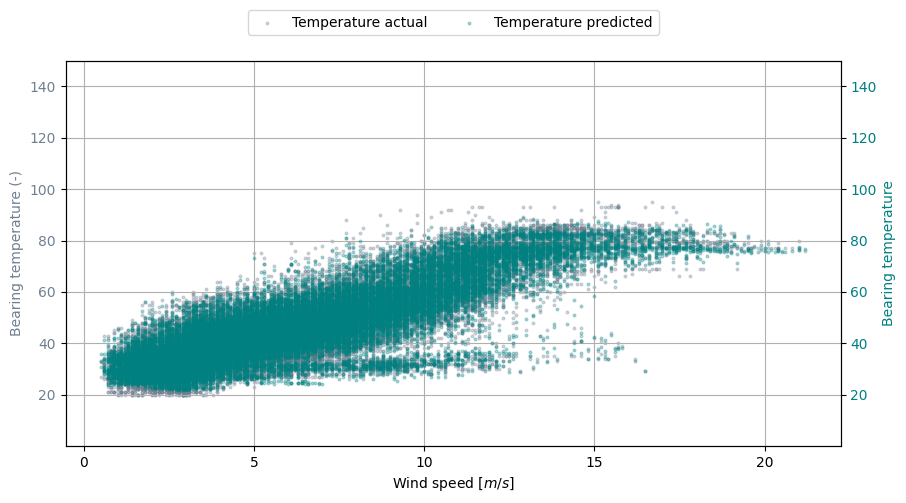

In [13]:
# Adjusted color scheme with burgundy and muted green
fig, ax1 = plt.subplots()  # Create a figure and axis

# Plotting the actual Cp values on the primary y-axis with burgundy
ax1.scatter(merged_df_filtered17_sorted["Amb_WindSpeed_Avg"], merged_df_filtered17_sorted["Gen_Bear_Temp_Avg"], color='slategrey', label='Temperature actual', alpha=0.3, marker='.', s=15)
ax1.set_xlabel('Wind speed [$m/s$]')  # x-axis label
ax1.set_ylabel('Bearing temperature (-)', color='slategrey')  # Primary y-axis label color
ax1.tick_params(axis='y', labelcolor='slategrey')  # Primary y-axis label tick color
ax1.grid()
ax1.set_ylim(0.1, 150)  # Set y-limits for Cp values

# Create a secondary y-axis with a muted green color
ax2 = ax1.twinx()  # Instantiate a second axes that shares the same x-axis
ax2.scatter(merged_df_filtered17_sorted["Amb_WindSpeed_Avg"], merged_df_filtered17_sorted["xgboost_pred_2017"], color='teal', label='Temperature predicted', alpha=0.3, marker='.', s=15)  # Muted olive green color
ax2.set_ylabel('Bearing temperature', color='teal')  # Secondary y-axis label color
ax2.tick_params(axis='y', labelcolor='teal')  # Secondary y-axis label tick color
ax2.set_ylim(0.1, 150)

# Optional: Add legends for both y-axes with subtle colors
fig.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), bbox_transform=ax1.transAxes, ncol=2)

# Show the plot
plt.show()

# Intervals:

In [14]:
# check units of the independent variables to make sure that interval is correctly chosen:
["Gen_Phase1_Temp_Avg", "Gen_RPM_Avg", "Avg_Windspeed1", "Nac_Temp_Avg", "Avg_Humidity"]
# Get a statistical summary for the other columns

windspeed_summary = merged_df_filtered17_sorted["Avg_Windspeed1"].describe()
nac_temp_summary = merged_df_filtered17_sorted["Nac_Temp_Avg"].describe()
humidity_summary = merged_df_filtered17_sorted["Avg_Humidity"].describe()
print(f"Avg Windspeed Summary:\n{windspeed_summary}")
print(f"Nac Temp Avg Summary:\n{nac_temp_summary}")
print(f"Avg Humidity Summary:\n{humidity_summary}")


Avg Windspeed Summary:
count    34581.000000
mean         6.257465
std          3.527416
min          0.000000
25%          3.600000
50%          5.600000
75%          8.400000
max         23.100000
Name: Avg_Windspeed1, dtype: float64
Nac Temp Avg Summary:
count    34582.000000
mean        31.666994
std          5.829491
min         17.000000
25%         28.000000
50%         32.000000
75%         36.000000
max         50.000000
Name: Nac_Temp_Avg, dtype: float64
Avg Humidity Summary:
count    34582.000000
mean        63.366694
std         17.430912
min         11.000000
25%         51.000000
50%         65.000000
75%         77.000000
max         99.000000
Name: Avg_Humidity, dtype: float64


In [15]:
humidity_interval = [-1,1]          # percentage? 
Gen_Phase1_Temp_interval = [-2,2]   # degrees
Gen_RPM_interval = [-1,1]           # RPM
Windspeed1_interval = [-1,1]        # m/s
Nac_Temp_interval = [-2,2]          # celcius

In [16]:
# Create and calculate 'max' columns using the average values and max of intervals
merged_df_filtered17_sorted["max_Humidity"] = merged_df_filtered17_sorted["Avg_Humidity"] + max(humidity_interval)
merged_df_filtered17_sorted["max_Gen_Phase1_Temp"] = merged_df_filtered17_sorted["Gen_Phase1_Temp_Avg"] + max(Gen_Phase1_Temp_interval)
merged_df_filtered17_sorted["max_Gen_RPM"] = merged_df_filtered17_sorted["Gen_RPM_Avg"] + max(Gen_RPM_interval)
merged_df_filtered17_sorted["max_Windspeed1"] = merged_df_filtered17_sorted["Avg_Windspeed1"] + max(Windspeed1_interval)
merged_df_filtered17_sorted["max_Nac_Temp"] = merged_df_filtered17_sorted["Nac_Temp_Avg"] + max(Nac_Temp_interval)

# Create and calculate 'min' columns using the average values and min of intervals
merged_df_filtered17_sorted["min_Humidity"] = merged_df_filtered17_sorted["Avg_Humidity"] + min(humidity_interval)
merged_df_filtered17_sorted["min_Gen_Phase1_Temp"] = merged_df_filtered17_sorted["Gen_Phase1_Temp_Avg"] + min(Gen_Phase1_Temp_interval)
merged_df_filtered17_sorted["min_Gen_RPM"] = merged_df_filtered17_sorted["Gen_RPM_Avg"] + min(Gen_RPM_interval)
merged_df_filtered17_sorted["min_Windspeed1"] = merged_df_filtered17_sorted["Avg_Windspeed1"] + min(Windspeed1_interval)
merged_df_filtered17_sorted["min_Nac_Temp"] = merged_df_filtered17_sorted["Nac_Temp_Avg"] + min(Nac_Temp_interval)


In [17]:
# Hva om vi lagde eit intervall for hvor utslitt utstyret er/ hvor lang tid til failure

In [18]:
print(model.get_booster().feature_names)

['Gen_Phase1_Temp_Avg', 'Gen_RPM_Avg', 'Avg_Windspeed1', 'Nac_Temp_Avg', 'Avg_Humidity']


In [19]:
import pandas as pd
import itertools

# Define the intervals
humidity_interval = [-2, 2]         # percentage %
Gen_Phase1_Temp_interval = [-2, 2]  # degrees Celcius
Gen_RPM_interval = [-1, 1]         # RPM
Windspeed1_interval = [-1, 1]      # m/s
Nac_Temp_interval = [-2, 2]        # Celsius

# Generate all 32 combinations of interval adjustments
combinations = list(itertools.product(
    humidity_interval,
    Gen_Phase1_Temp_interval,
    Gen_RPM_interval,
    Windspeed1_interval,
    Nac_Temp_interval
))

# Iterate through the 32 combinations
for idx, combo in enumerate(combinations):
    humidity_val, Gen_Phase1_Temp_val, Gen_RPM_val, Windspeed_val, Nac_Temp_val = combo

    # Apply the combination adjustments to the time series
    X_test = pd.DataFrame({
        'Gen_Phase1_Temp_Avg': merged_df_filtered17_sorted["Gen_Phase1_Temp_Avg"] + Gen_Phase1_Temp_val,
        'Gen_RPM_Avg': merged_df_filtered17_sorted["Gen_RPM_Avg"] + Gen_RPM_val,
        'Avg_Windspeed1': merged_df_filtered17_sorted["Avg_Windspeed1"] + Windspeed_val,
        'Nac_Temp_Avg': merged_df_filtered17_sorted["Nac_Temp_Avg"] + Nac_Temp_val,
        'Avg_Humidity': merged_df_filtered17_sorted["Avg_Humidity"] + humidity_val
    })

    # Predict with the model for the entire time series
    predictions = model.predict(X_test)

    # Store predictions in the DataFrame
    merged_df_filtered17_sorted[f'pred_comb_{idx+1}'] = predictions

    print(f"Combination {idx+1}: Prediction completed for the entire time series.")

# Optionally, you can save or visualize the modified DataFrame
# For example:
# merged_df_filtered17_sorted.to_csv('predictions_with_combinations.csv', index=False)


Combination 1: Prediction completed for the entire time series.
Combination 2: Prediction completed for the entire time series.
Combination 3: Prediction completed for the entire time series.
Combination 4: Prediction completed for the entire time series.
Combination 5: Prediction completed for the entire time series.
Combination 6: Prediction completed for the entire time series.
Combination 7: Prediction completed for the entire time series.
Combination 8: Prediction completed for the entire time series.
Combination 9: Prediction completed for the entire time series.
Combination 10: Prediction completed for the entire time series.
Combination 11: Prediction completed for the entire time series.
Combination 12: Prediction completed for the entire time series.
Combination 13: Prediction completed for the entire time series.
Combination 14: Prediction completed for the entire time series.
Combination 15: Prediction completed for the entire time series.
Combination 16: Prediction complet

In [20]:
# Define the 'min' and 'max' columns
min_columns = ["min_Humidity", "min_Gen_Phase1_Temp", "min_Gen_RPM", "min_Windspeed1", "min_Nac_Temp"]
max_columns = ["max_Humidity", "max_Gen_Phase1_Temp", "max_Gen_RPM", "max_Windspeed1", "max_Nac_Temp"]

# Generate all 32 combinations of 'min' and 'max' features
combinations = []
for i in range(32):
    combination = []
    for j in range(5):
        if (i >> j) & 1:
            combination.append(max_columns[j])  # Use max for this feature
        else:
            combination.append(min_columns[j])  # Use min for this feature
    combinations.append(combination)

# Ensure the correct feature order for the model
feature_columns = ["Gen_Phase1_Temp_Avg", "Gen_RPM_Avg", "Avg_Windspeed1", "Nac_Temp_Avg", "Avg_Humidity"]

# Predict for each combination
for idx, comb in enumerate(combinations, 1):
    # Prepare feature set for the current combination
    combination_features = merged_df_filtered17_sorted[comb].copy()
    
    # Rename columns to match the correct feature names and order
    combination_features.columns = feature_columns
    
    # Reorder columns to ensure proper order (optional, but ensures consistency)
    combination_features = combination_features[feature_columns]
    
    # Generate predictions for the current combination
    predictions = model.predict(combination_features)
    
    # Add predictions to the DataFrame as a new column
    merged_df_filtered17_sorted[f"combination_{idx}_prediction"] = predictions

# Check results
print(merged_df_filtered17_sorted.head())


      Turbine_ID                 Timestamp  Gen_RPM_Max  Gen_RPM_Min  \
87615        T07 2017-01-01 00:00:00+00:00       1513.4       1255.3   
37433        T07 2017-01-01 00:10:00+00:00       1485.4       1243.1   
54937        T07 2017-01-01 00:20:00+00:00       1505.3       1255.1   
87608        T07 2017-01-01 00:30:00+00:00       1486.6       1246.1   
19102        T07 2017-01-01 00:40:00+00:00       1381.6       1241.4   

       Gen_RPM_Avg  Gen_RPM_Std  Gen_Bear_Temp_Avg  Gen_Phase1_Temp_Avg  \
87615       1336.5         47.6               36.0                   58   
37433       1307.9         34.7               36.0                   58   
54937       1325.9         41.4               36.0                   58   
87608       1322.4         44.7               36.0                   58   
19102       1292.4         31.1               36.0                   58   

       Gen_Phase2_Temp_Avg  Gen_Phase3_Temp_Avg  ...  \
87615                   58                   58  ...   
3743

In [21]:
# Ensure correct feature order for predictions
feature_columns = ["Gen_Phase1_Temp_Avg", "Gen_RPM_Avg", "Avg_Windspeed1", "Nac_Temp_Avg", "Avg_Humidity"]

# Verify the range of min and max columns
for col in min_columns + max_columns:
    print(f"{col} - Min: {merged_df_filtered17_sorted[col].min()}, Max: {merged_df_filtered17_sorted[col].max()}")

# Predict for each combination
for idx, comb in enumerate(combinations, 1):
    # Prepare feature set for the current combination
    combination_features = merged_df_filtered17_sorted[comb].copy()
    
    # Rename columns to match the correct feature names and order
    combination_features.columns = feature_columns
    
    # Ensure alignment of feature columns with the model's expectations
    combination_features = combination_features[feature_columns]
    
    # Debug: Check the range of features before prediction
    print(f"Combination {idx} - Feature ranges:")
    print(combination_features.describe())
    
    # Generate predictions
    predictions = model.predict(combination_features)
    
    # Add predictions to the DataFrame
    merged_df_filtered17_sorted[f"combination_{idx}_prediction"] = predictions



min_Humidity - Min: 10, Max: 98
min_Gen_Phase1_Temp - Min: 22, Max: 143
min_Gen_RPM - Min: -1.0, Max: 1682.8
min_Windspeed1 - Min: -1.0, Max: 22.1
min_Nac_Temp - Min: 15, Max: 48
max_Humidity - Min: 12, Max: 100
max_Gen_Phase1_Temp - Min: 26, Max: 147
max_Gen_RPM - Min: 1.0, Max: 1684.8
max_Windspeed1 - Min: 1.0, Max: 24.1
max_Nac_Temp - Min: 19, Max: 52
Combination 1 - Feature ranges:
       Gen_Phase1_Temp_Avg   Gen_RPM_Avg  Avg_Windspeed1  Nac_Temp_Avg  \
count         34582.000000  34582.000000    34582.000000  34581.000000   
mean             62.366694     66.326933     1066.409869      5.257465   
std              17.430912     29.825126      611.287551      3.527416   
min              10.000000     22.000000       -1.000000     -1.000000   
25%              50.000000     43.000000      282.000000      2.600000   
50%              64.000000     62.000000     1265.600000      4.600000   
75%              76.000000     80.000000     1602.500000      7.400000   
max              98

In [22]:
combinations

[['min_Humidity',
  'min_Gen_Phase1_Temp',
  'min_Gen_RPM',
  'min_Windspeed1',
  'min_Nac_Temp'],
 ['max_Humidity',
  'min_Gen_Phase1_Temp',
  'min_Gen_RPM',
  'min_Windspeed1',
  'min_Nac_Temp'],
 ['min_Humidity',
  'max_Gen_Phase1_Temp',
  'min_Gen_RPM',
  'min_Windspeed1',
  'min_Nac_Temp'],
 ['max_Humidity',
  'max_Gen_Phase1_Temp',
  'min_Gen_RPM',
  'min_Windspeed1',
  'min_Nac_Temp'],
 ['min_Humidity',
  'min_Gen_Phase1_Temp',
  'max_Gen_RPM',
  'min_Windspeed1',
  'min_Nac_Temp'],
 ['max_Humidity',
  'min_Gen_Phase1_Temp',
  'max_Gen_RPM',
  'min_Windspeed1',
  'min_Nac_Temp'],
 ['min_Humidity',
  'max_Gen_Phase1_Temp',
  'max_Gen_RPM',
  'min_Windspeed1',
  'min_Nac_Temp'],
 ['max_Humidity',
  'max_Gen_Phase1_Temp',
  'max_Gen_RPM',
  'min_Windspeed1',
  'min_Nac_Temp'],
 ['min_Humidity',
  'min_Gen_Phase1_Temp',
  'min_Gen_RPM',
  'max_Windspeed1',
  'min_Nac_Temp'],
 ['max_Humidity',
  'min_Gen_Phase1_Temp',
  'min_Gen_RPM',
  'max_Windspeed1',
  'min_Nac_Temp'],
 ['min_Hum

In [23]:
"""import matplotlib.pyplot as plt

# Plot predictions for all 32 combinations with subplots
fig, axes = plt.subplots(8, 4, figsize=(15, 20))  # 8x4 grid for 32 combinations
axes = axes.flatten()  # Flatten the 2D grid for easy iteration

# Iterate through combinations
for idx, combo in enumerate(combinations):
    humidity_val, Gen_Phase1_Temp_val, Gen_RPM_val, Windspeed_val, Nac_Temp_val = combo

    X_test = pd.DataFrame({
        'Gen_Phase1_Temp_Avg': merged_df_filtered17_sorted["Gen_Phase1_Temp_Avg"] + Gen_Phase1_Temp_val,
        'Gen_RPM_Avg': merged_df_filtered17_sorted["Gen_RPM_Avg"] + Gen_RPM_val,
        'Avg_Windspeed1': merged_df_filtered17_sorted["Avg_Windspeed1"] + Windspeed_val,
        'Nac_Temp_Avg': merged_df_filtered17_sorted["Nac_Temp_Avg"] + Nac_Temp_val,
        'Avg_Humidity': merged_df_filtered17_sorted["Avg_Humidity"] + humidity_val
    })

    # Predict with the model
    predictions = model.predict(X_test)
    merged_df_filtered17_sorted[f'pred_comb_{idx+1}'] = predictions

    ax = axes[idx]
    ax.scatter(merged_df_filtered17_sorted["Amb_WindSpeed_Avg"], merged_df_filtered17_sorted["Gen_Bear_Temp_Avg"],
               color='slategrey', alpha=0.3, marker='.', s=15, label='Temperature actual')
    ax2 = ax.twinx()  # Create a secondary y-axis
    ax2.scatter(merged_df_filtered17_sorted["Amb_WindSpeed_Avg"], predictions,
                color='teal', alpha=0.3, marker='.', s=15, label=f'Pred_comb_{idx+1}')

    ax.set_title(f'Combination {idx+1}')
    ax.set_xlabel('Wind Speed [$m/s$]')
    ax.set_ylabel('Bearing Temperature (-)', color='slategrey')
    ax.tick_params(axis='y', labelcolor='slategrey')
    ax2.set_ylabel('Predictions', color='teal')

# Show the overall plot
plt.tight_layout()
plt.show()
"""

'import matplotlib.pyplot as plt\n\n# Plot predictions for all 32 combinations with subplots\nfig, axes = plt.subplots(8, 4, figsize=(15, 20))  # 8x4 grid for 32 combinations\naxes = axes.flatten()  # Flatten the 2D grid for easy iteration\n\n# Iterate through combinations\nfor idx, combo in enumerate(combinations):\n    humidity_val, Gen_Phase1_Temp_val, Gen_RPM_val, Windspeed_val, Nac_Temp_val = combo\n\n    X_test = pd.DataFrame({\n        \'Gen_Phase1_Temp_Avg\': merged_df_filtered17_sorted["Gen_Phase1_Temp_Avg"] + Gen_Phase1_Temp_val,\n        \'Gen_RPM_Avg\': merged_df_filtered17_sorted["Gen_RPM_Avg"] + Gen_RPM_val,\n        \'Avg_Windspeed1\': merged_df_filtered17_sorted["Avg_Windspeed1"] + Windspeed_val,\n        \'Nac_Temp_Avg\': merged_df_filtered17_sorted["Nac_Temp_Avg"] + Nac_Temp_val,\n        \'Avg_Humidity\': merged_df_filtered17_sorted["Avg_Humidity"] + humidity_val\n    })\n\n    # Predict with the model\n    predictions = model.predict(X_test)\n    merged_df_filtered1

In [24]:

print(merged_df_filtered17_sorted.iloc[0])


Turbine_ID                                         T07
Timestamp                    2017-01-01 00:00:00+00:00
Gen_RPM_Max                                     1513.4
Gen_RPM_Min                                     1255.3
Gen_RPM_Avg                                     1336.5
                                       ...            
combination_28_prediction                    46.956501
combination_29_prediction                    47.429569
combination_30_prediction                    46.956501
combination_31_prediction                    47.429569
combination_32_prediction                    46.956501
Name: 87615, Length: 198, dtype: object


In [25]:
"""print(merged_df_filtered17_sorted["humidity_val"]) # View the first 5 rows"""


'print(merged_df_filtered17_sorted["humidity_val"]) # View the first 5 rows'

In [26]:
# Display the first 5 rows of the DataFrame
print(merged_df_filtered17_sorted.head())


      Turbine_ID                 Timestamp  Gen_RPM_Max  Gen_RPM_Min  \
87615        T07 2017-01-01 00:00:00+00:00       1513.4       1255.3   
37433        T07 2017-01-01 00:10:00+00:00       1485.4       1243.1   
54937        T07 2017-01-01 00:20:00+00:00       1505.3       1255.1   
87608        T07 2017-01-01 00:30:00+00:00       1486.6       1246.1   
19102        T07 2017-01-01 00:40:00+00:00       1381.6       1241.4   

       Gen_RPM_Avg  Gen_RPM_Std  Gen_Bear_Temp_Avg  Gen_Phase1_Temp_Avg  \
87615       1336.5         47.6               36.0                   58   
37433       1307.9         34.7               36.0                   58   
54937       1325.9         41.4               36.0                   58   
87608       1322.4         44.7               36.0                   58   
19102       1292.4         31.1               36.0                   58   

       Gen_Phase2_Temp_Avg  Gen_Phase3_Temp_Avg  ...  \
87615                   58                   58  ...   
3743

In [27]:
combinations

[['min_Humidity',
  'min_Gen_Phase1_Temp',
  'min_Gen_RPM',
  'min_Windspeed1',
  'min_Nac_Temp'],
 ['max_Humidity',
  'min_Gen_Phase1_Temp',
  'min_Gen_RPM',
  'min_Windspeed1',
  'min_Nac_Temp'],
 ['min_Humidity',
  'max_Gen_Phase1_Temp',
  'min_Gen_RPM',
  'min_Windspeed1',
  'min_Nac_Temp'],
 ['max_Humidity',
  'max_Gen_Phase1_Temp',
  'min_Gen_RPM',
  'min_Windspeed1',
  'min_Nac_Temp'],
 ['min_Humidity',
  'min_Gen_Phase1_Temp',
  'max_Gen_RPM',
  'min_Windspeed1',
  'min_Nac_Temp'],
 ['max_Humidity',
  'min_Gen_Phase1_Temp',
  'max_Gen_RPM',
  'min_Windspeed1',
  'min_Nac_Temp'],
 ['min_Humidity',
  'max_Gen_Phase1_Temp',
  'max_Gen_RPM',
  'min_Windspeed1',
  'min_Nac_Temp'],
 ['max_Humidity',
  'max_Gen_Phase1_Temp',
  'max_Gen_RPM',
  'min_Windspeed1',
  'min_Nac_Temp'],
 ['min_Humidity',
  'min_Gen_Phase1_Temp',
  'min_Gen_RPM',
  'max_Windspeed1',
  'min_Nac_Temp'],
 ['max_Humidity',
  'min_Gen_Phase1_Temp',
  'min_Gen_RPM',
  'max_Windspeed1',
  'min_Nac_Temp'],
 ['min_Hum

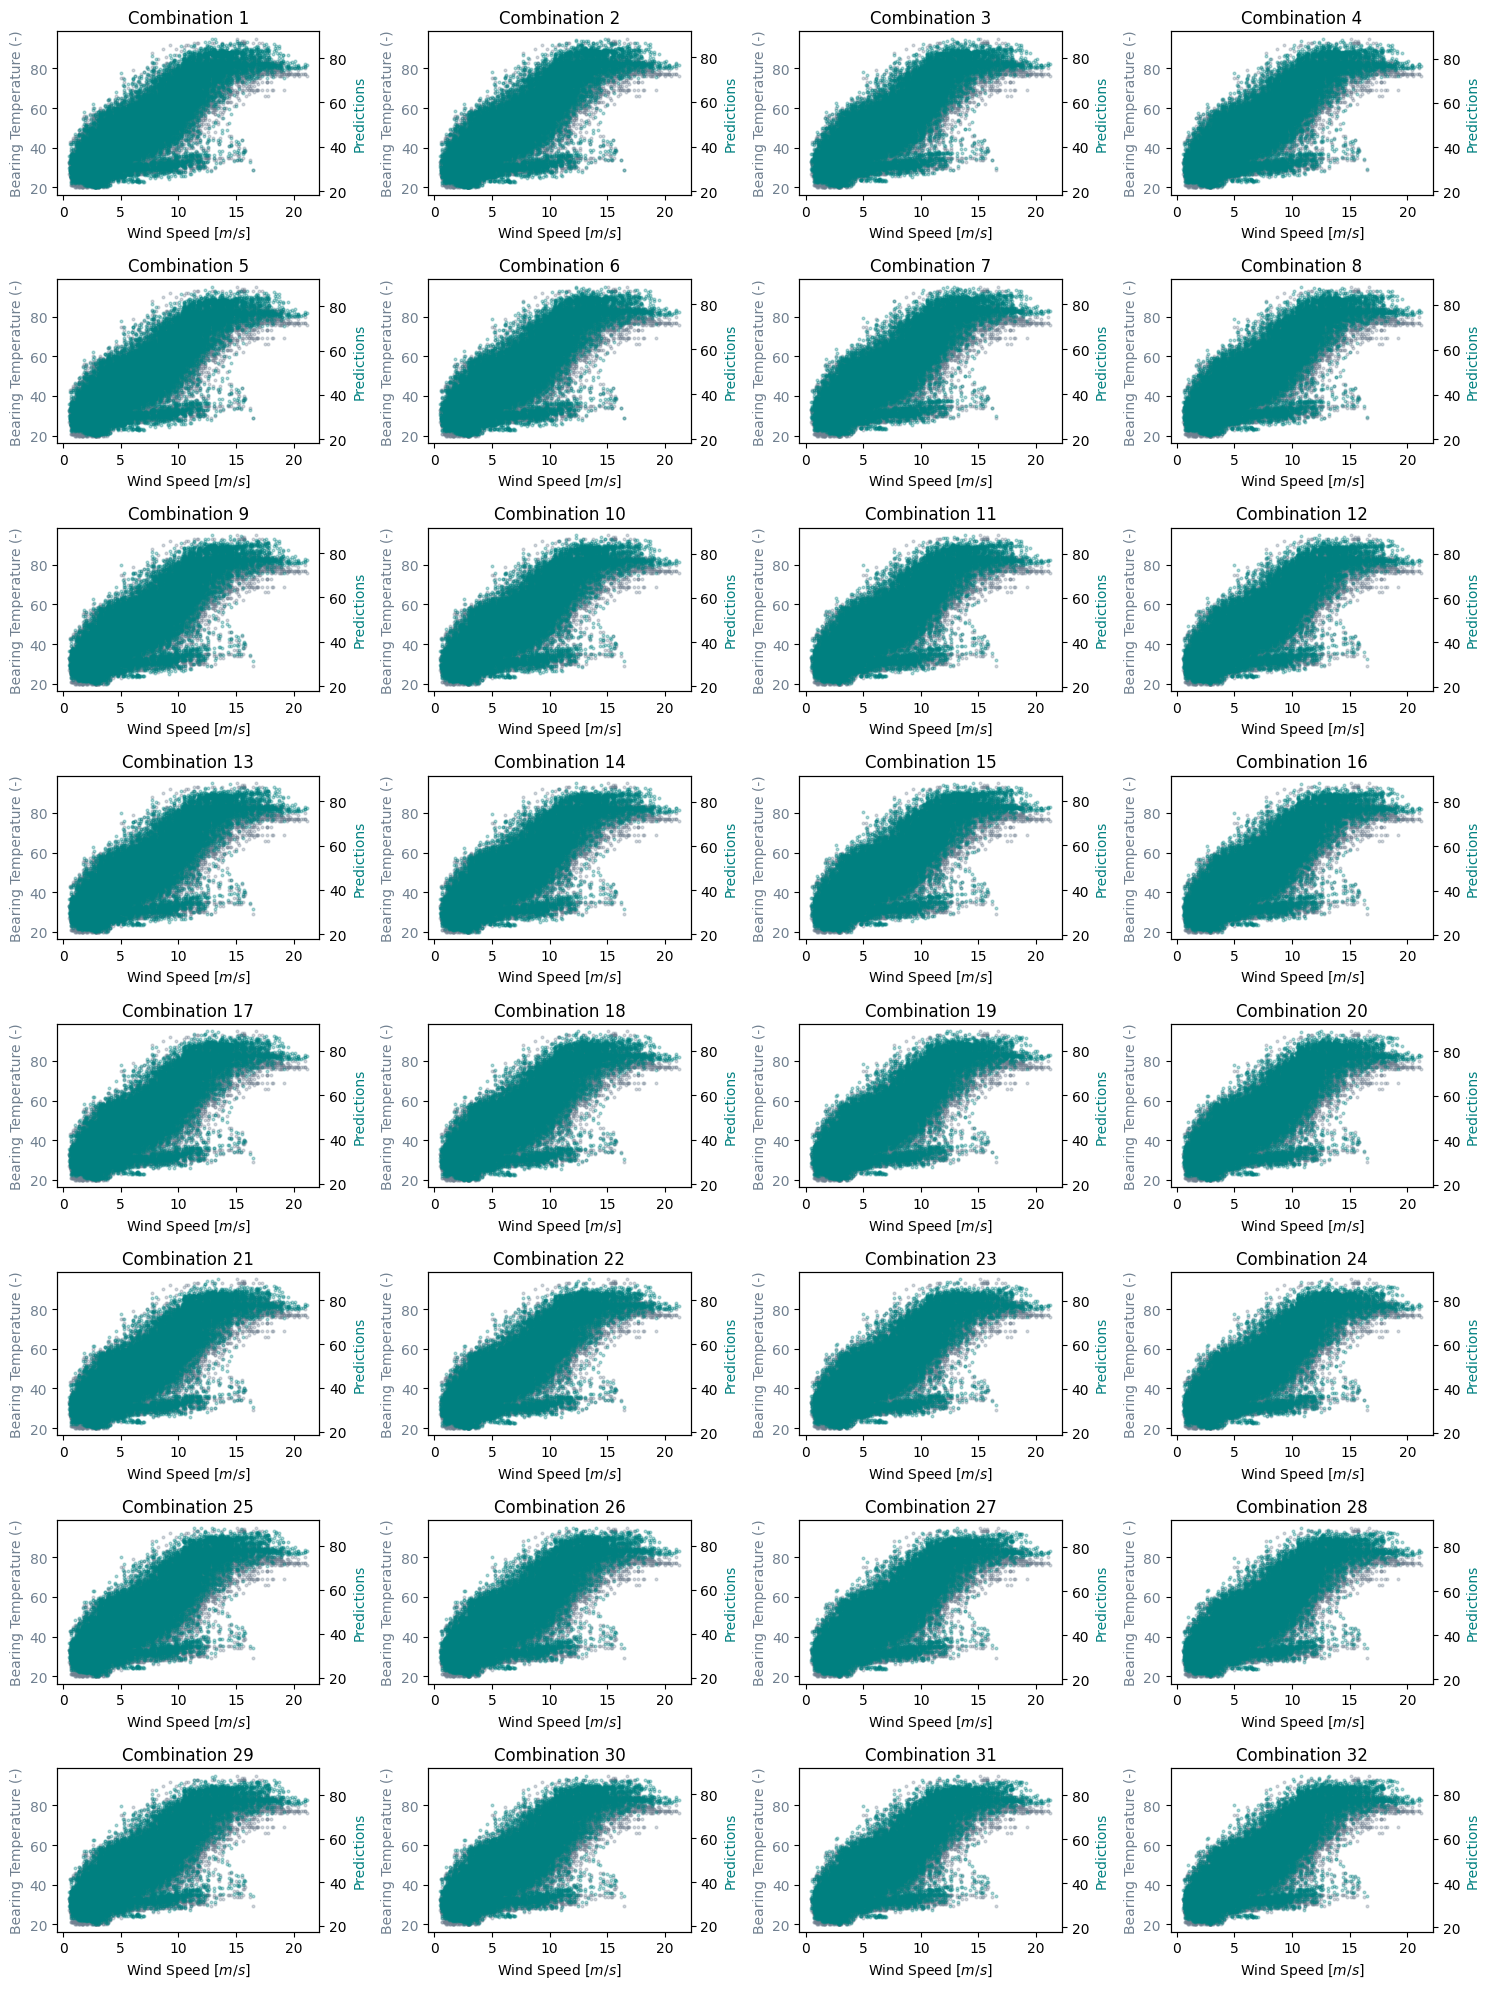

In [28]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure relevant columns are numeric
merged_df_filtered17_sorted["Amb_WindSpeed_Avg"] = pd.to_numeric(merged_df_filtered17_sorted["Amb_WindSpeed_Avg"], errors="coerce")
merged_df_filtered17_sorted["Gen_Bear_Temp_Avg"] = pd.to_numeric(merged_df_filtered17_sorted["Gen_Bear_Temp_Avg"], errors="coerce")

# Plot predictions for all 32 combinations with subplots
fig, axes = plt.subplots(8, 4, figsize=(15, 20))  # 8x4 grid for 32 combinations
axes = axes.flatten()  # Flatten the 2D grid for easy iteration

# Iterate through combinations
for idx, combo in enumerate(combinations):
    # Prepare values from combinations
    humidity_val = 0 if 'min_Humidity' in combo else 1
    Gen_Phase1_Temp_val = 0 if 'min_Gen_Phase1_Temp' in combo else 1
    Gen_RPM_val = 0 if 'min_Gen_RPM' in combo else 1
    Windspeed_val = 0 if 'min_Windspeed1' in combo else 1
    Nac_Temp_val = 0 if 'min_Nac_Temp' in combo else 1

    # Create a test DataFrame
    X_test = pd.DataFrame({
        "Gen_Phase1_Temp_Avg": merged_df_filtered17_sorted["Gen_Phase1_Temp_Avg"] + Gen_Phase1_Temp_val,
        "Gen_RPM_Avg": merged_df_filtered17_sorted["Gen_RPM_Avg"] + Gen_RPM_val,
        "Avg_Windspeed1": merged_df_filtered17_sorted["Avg_Windspeed1"] + Windspeed_val,
        "Nac_Temp_Avg": merged_df_filtered17_sorted["Nac_Temp_Avg"] + Nac_Temp_val,
        "Avg_Humidity": merged_df_filtered17_sorted["Avg_Humidity"] + humidity_val
    })

    # Predict with the model
    predictions = model.predict(X_test)
    merged_df_filtered17_sorted[f"pred_comb_{idx+1}"] = predictions

    # Scatter plots
    ax = axes[idx]
    ax.scatter(merged_df_filtered17_sorted["Amb_WindSpeed_Avg"], merged_df_filtered17_sorted["Gen_Bear_Temp_Avg"],
               color="slategrey", alpha=0.3, marker=".", s=15, label="Temperature actual")
    ax2 = ax.twinx()  # Create a secondary y-axis
    ax2.scatter(merged_df_filtered17_sorted["Amb_WindSpeed_Avg"], predictions,
                color="teal", alpha=0.3, marker=".", s=15, label=f"Pred_comb_{idx+1}")

    # Set titles and labels
    ax.set_title(f"Combination {idx+1}")
    ax.set_xlabel("Wind Speed [$m/s$]")
    ax.set_ylabel("Bearing Temperature (-)", color="slategrey")
    ax.tick_params(axis="y", labelcolor="slategrey")
    ax2.set_ylabel("Predictions", color="teal")

# Show the overall plot
plt.tight_layout()
plt.show()


In [29]:
"""import matplotlib.pyplot as plt
import pandas as pd

# Identify prediction columns (e.g., columns starting with 'pred_comb_')
prediction_columns = [col for col in merged_df_filtered17_sorted.columns if col.startswith('pred_comb_')]

# Ensure numeric types for prediction columns
merged_df_filtered17_sorted[prediction_columns] = merged_df_filtered17_sorted[prediction_columns].apply(pd.to_numeric, errors='coerce')

# Compute row-wise min and max for prediction columns
merged_df_filtered17_sorted['row_min'] = merged_df_filtered17_sorted[prediction_columns].min(axis=1)
merged_df_filtered17_sorted['row_max'] = merged_df_filtered17_sorted[prediction_columns].max(axis=1)

# Scatter plot of min and max predictions
plt.figure(figsize=(10, 6))

# Scatter for min predictions
plt.scatter(merged_df_filtered17_sorted["Amb_WindSpeed_Avg"], 
            merged_df_filtered17_sorted["row_min"], 
            color='blue', alpha=0.5, label='Row Min Predictions', s=15)

# Scatter for max predictions
plt.scatter(merged_df_filtered17_sorted["Amb_WindSpeed_Avg"], 
            merged_df_filtered17_sorted["row_max"], 
            color='red', alpha=0.5, label='Row Max Predictions', s=15)

# Plot settings
plt.xlabel('Wind Speed [$m/s$]')
plt.ylabel('Predictions')
plt.title('Row-wise Min and Max Predictions Across Combinations')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
"""

'import matplotlib.pyplot as plt\nimport pandas as pd\n\n# Identify prediction columns (e.g., columns starting with \'pred_comb_\')\nprediction_columns = [col for col in merged_df_filtered17_sorted.columns if col.startswith(\'pred_comb_\')]\n\n# Ensure numeric types for prediction columns\nmerged_df_filtered17_sorted[prediction_columns] = merged_df_filtered17_sorted[prediction_columns].apply(pd.to_numeric, errors=\'coerce\')\n\n# Compute row-wise min and max for prediction columns\nmerged_df_filtered17_sorted[\'row_min\'] = merged_df_filtered17_sorted[prediction_columns].min(axis=1)\nmerged_df_filtered17_sorted[\'row_max\'] = merged_df_filtered17_sorted[prediction_columns].max(axis=1)\n\n# Scatter plot of min and max predictions\nplt.figure(figsize=(10, 6))\n\n# Scatter for min predictions\nplt.scatter(merged_df_filtered17_sorted["Amb_WindSpeed_Avg"], \n            merged_df_filtered17_sorted["row_min"], \n            color=\'blue\', alpha=0.5, label=\'Row Min Predictions\', s=15)\n\n#

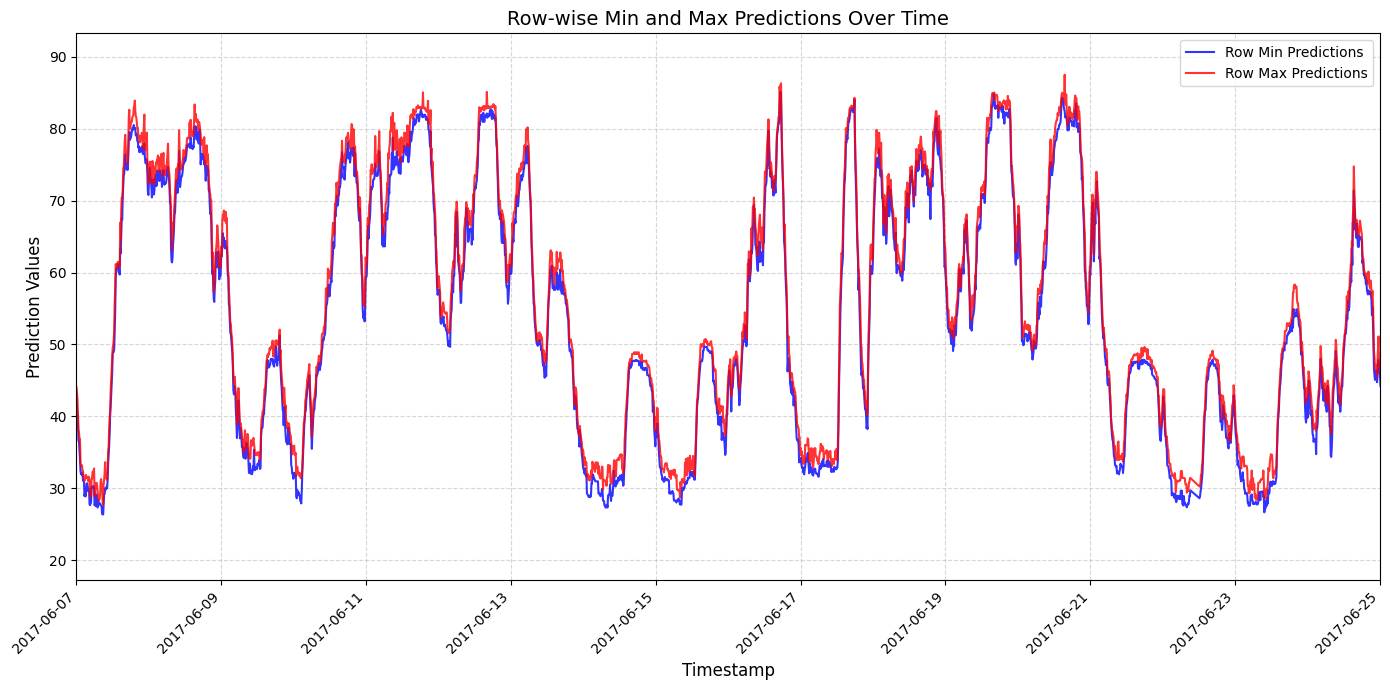

In [30]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure Timestamp column is in datetime format
merged_df_filtered17_sorted["Timestamp"] = pd.to_datetime(merged_df_filtered17_sorted["Timestamp"])

# Sort the DataFrame by Timestamp for proper chronological plotting
merged_df_filtered17_sorted = merged_df_filtered17_sorted.sort_values(by="Timestamp")

# Identify prediction columns
prediction_columns = [col for col in merged_df_filtered17_sorted.columns if col.startswith('pred_comb_')]

# Ensure prediction columns are numeric
merged_df_filtered17_sorted[prediction_columns] = merged_df_filtered17_sorted[prediction_columns].apply(pd.to_numeric, errors='coerce')

# Compute row-wise min and max for prediction columns
merged_df_filtered17_sorted["row_min"] = merged_df_filtered17_sorted[prediction_columns].min(axis=1)
merged_df_filtered17_sorted["row_max"] = merged_df_filtered17_sorted[prediction_columns].max(axis=1)

# Plot min and max predictions over time
plt.figure(figsize=(14, 7))

# Line plot for row-wise minimum predictions
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted["row_min"], 
    color='blue', alpha=0.8, label='Row Min Predictions', linewidth=1.5
)

# Line plot for row-wise maximum predictions
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted["row_max"], 
    color='red', alpha=0.8, label='Row Max Predictions', linewidth=1.5
)

# Highlight x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Optional: Define interval for x-axis if needed (adjust start and end dates)
plt.xlim(pd.to_datetime('2017-06-07'), pd.to_datetime('2017-06-25'))

# Title and labels
plt.title("Row-wise Min and Max Predictions Over Time", fontsize=14)
plt.xlabel("Timestamp", fontsize=12)
plt.ylabel("Prediction Values", fontsize=12)

# Legend and grid for clarity
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()


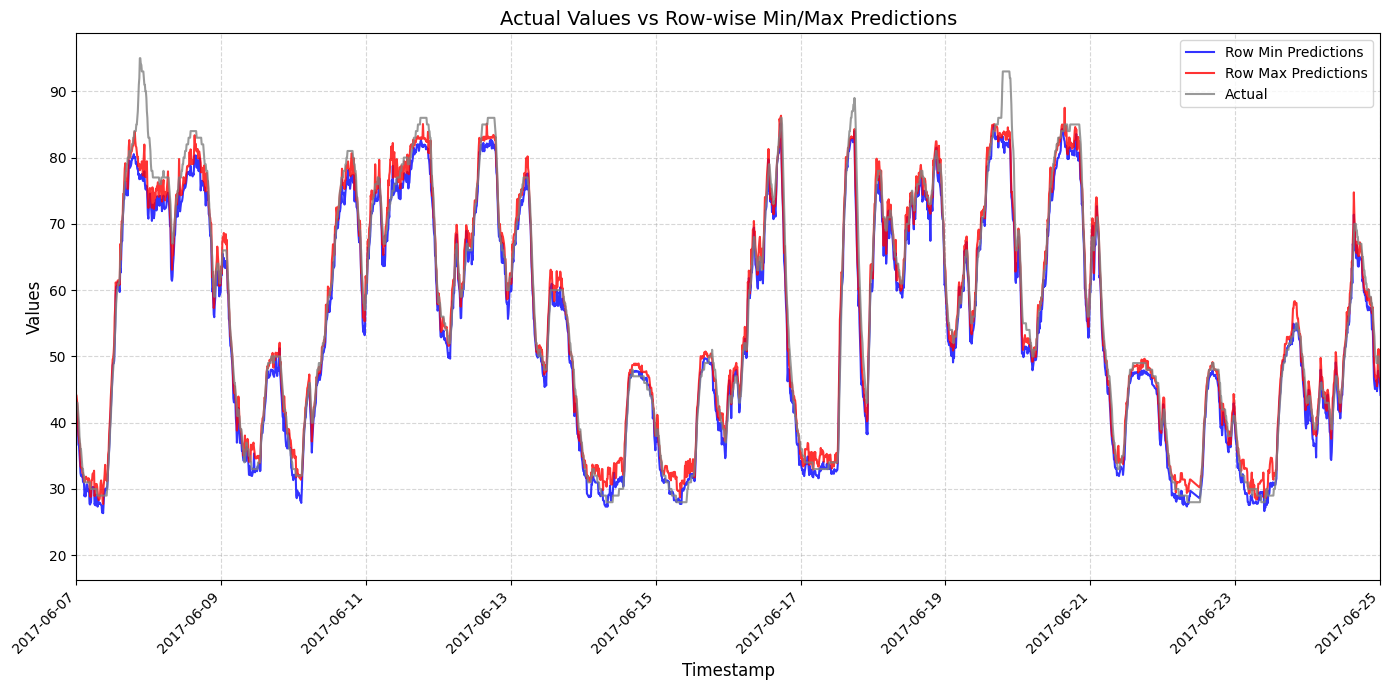

In [31]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure Timestamp column is in datetime format
merged_df_filtered17_sorted["Timestamp"] = pd.to_datetime(merged_df_filtered17_sorted["Timestamp"])

# Sort the DataFrame by Timestamp for proper chronological plotting
merged_df_filtered17_sorted = merged_df_filtered17_sorted.sort_values(by="Timestamp")

# Identify prediction columns
prediction_columns = [col for col in merged_df_filtered17_sorted.columns if col.startswith('pred_comb_')]

# Ensure prediction columns are numeric
merged_df_filtered17_sorted[prediction_columns] = merged_df_filtered17_sorted[prediction_columns].apply(pd.to_numeric, errors='coerce')

# Compute row-wise min and max for prediction columns
merged_df_filtered17_sorted["row_min"] = merged_df_filtered17_sorted[prediction_columns].min(axis=1)
merged_df_filtered17_sorted["row_max"] = merged_df_filtered17_sorted[prediction_columns].max(axis=1)

# Plot
plt.figure(figsize=(14, 7))

# Line plot for row-wise minimum predictions
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted["row_min"], 
    color='blue', alpha=0.8, label='Row Min Predictions', linewidth=1.5
)

# Line plot for row-wise maximum predictions
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted["row_max"], 
    color='red', alpha=0.8, label='Row Max Predictions', linewidth=1.5
)

# Line plot for actual values
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted[target_column],  # Actual target values
    color='grey', alpha=0.8, label='Actual', linestyle='-', linewidth=1.5
)

# Highlight x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Optional: Define interval for x-axis if needed (adjust start and end dates)
plt.xlim(pd.to_datetime('2017-06-07'), pd.to_datetime('2017-06-25'))

# Title and labels
plt.title("Actual Values vs Row-wise Min/Max Predictions", fontsize=14)
plt.xlabel("Timestamp", fontsize=12)
plt.ylabel("Values", fontsize=12)

# Legend and grid for clarity
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()


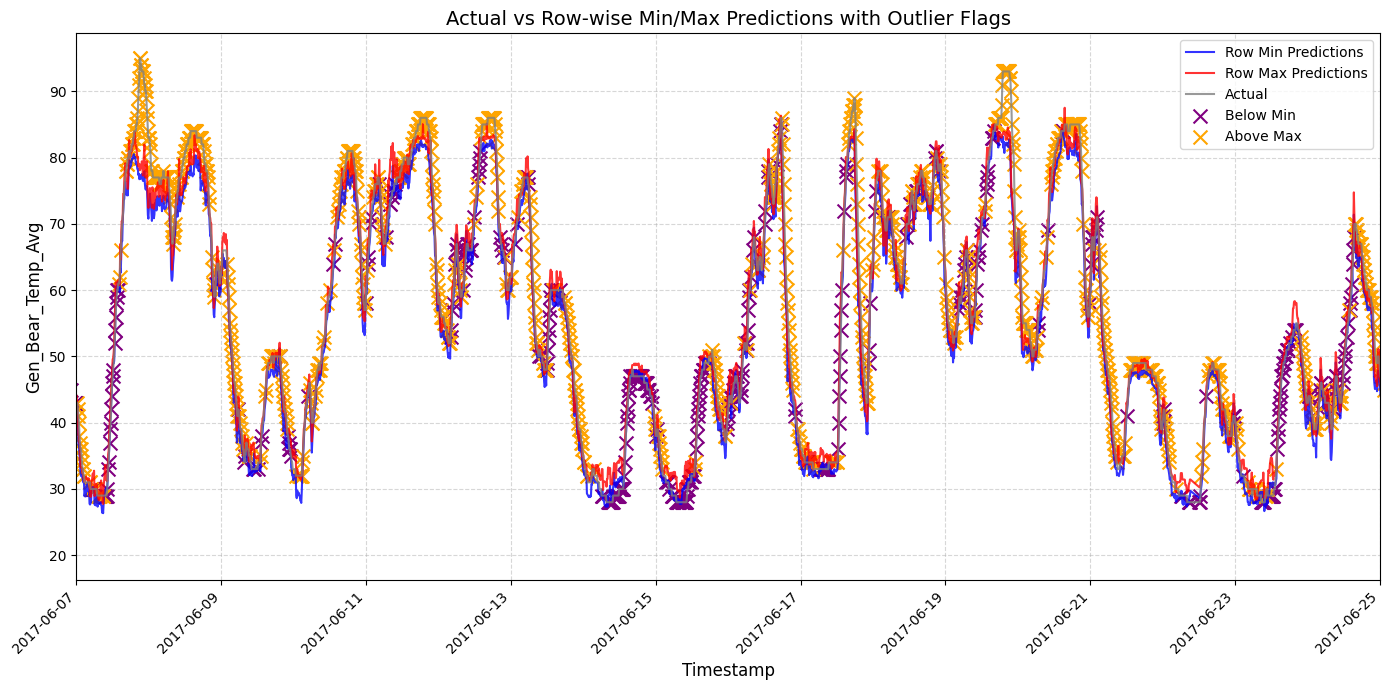

In [32]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure Timestamp column is in datetime format
merged_df_filtered17_sorted["Timestamp"] = pd.to_datetime(merged_df_filtered17_sorted["Timestamp"])

# Sort the DataFrame by Timestamp
merged_df_filtered17_sorted = merged_df_filtered17_sorted.sort_values(by="Timestamp")

# Identify prediction columns
prediction_columns = [col for col in merged_df_filtered17_sorted.columns if col.startswith('pred_comb_')]

# Ensure prediction columns are numeric
merged_df_filtered17_sorted[prediction_columns] = merged_df_filtered17_sorted[prediction_columns].apply(pd.to_numeric, errors='coerce')

# Compute row-wise min and max for prediction columns
merged_df_filtered17_sorted["row_min"] = merged_df_filtered17_sorted[prediction_columns].min(axis=1)
merged_df_filtered17_sorted["row_max"] = merged_df_filtered17_sorted[prediction_columns].max(axis=1)

# Flag where actual values are outside the row-wise min and max
merged_df_filtered17_sorted["below_min"] = (merged_df_filtered17_sorted[target_column] < merged_df_filtered17_sorted["row_min"]).astype(int)
merged_df_filtered17_sorted["above_max"] = (merged_df_filtered17_sorted[target_column] > merged_df_filtered17_sorted["row_max"]).astype(int)

# Plot
plt.figure(figsize=(14, 7))

# Line plot for row-wise minimum predictions
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted["row_min"], 
    color='blue', alpha=0.8, label='Row Min Predictions', linewidth=1.5
)

# Line plot for row-wise maximum predictions
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted["row_max"], 
    color='red', alpha=0.8, label='Row Max Predictions', linewidth=1.5
)

# Line plot for actual values
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted[target_column],  
    color='grey', alpha=0.8, label='Actual', linestyle='-', linewidth=1.5
)

# Scatter points where actual is below row_min
plt.scatter(
    merged_df_filtered17_sorted["Timestamp"][merged_df_filtered17_sorted["below_min"] == 1],
    merged_df_filtered17_sorted[target_column][merged_df_filtered17_sorted["below_min"] == 1],
    color='purple', marker='x', s=100, label='Below Min'
)

# Scatter points where actual is above row_max
plt.scatter(
    merged_df_filtered17_sorted["Timestamp"][merged_df_filtered17_sorted["above_max"] == 1],
    merged_df_filtered17_sorted[target_column][merged_df_filtered17_sorted["above_max"] == 1],
    color='orange', marker='x', s=100, label='Above Max'
)

# Highlight x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Define interval for x-axis (adjust as needed)
plt.xlim(pd.to_datetime('2017-06-07'), pd.to_datetime('2017-06-25'))

# Title and labels
plt.title("Actual vs Row-wise Min/Max Predictions with Outlier Flags", fontsize=14)
plt.xlabel("Timestamp", fontsize=12)
plt.ylabel(target_column, fontsize=12)

# Legend and grid for clarity
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()


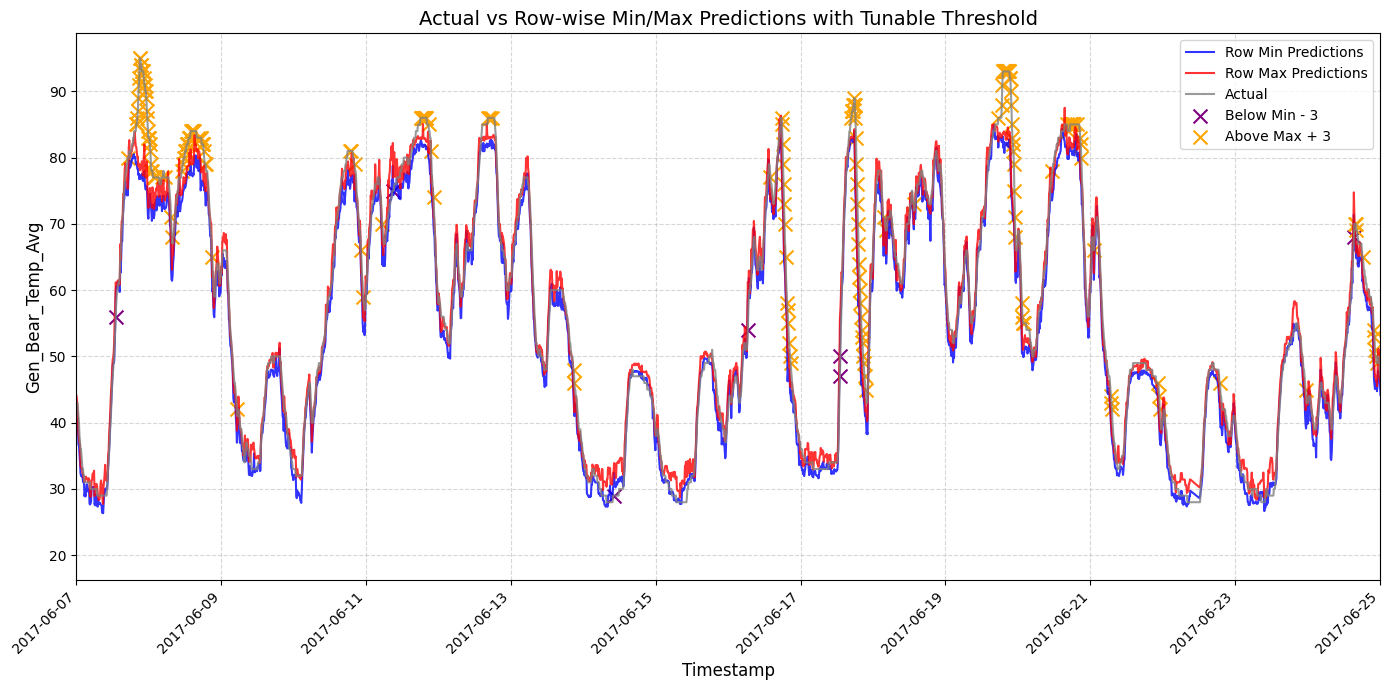

In [33]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure Timestamp column is in datetime format
merged_df_filtered17_sorted["Timestamp"] = pd.to_datetime(merged_df_filtered17_sorted["Timestamp"])

# Sort the DataFrame by Timestamp
merged_df_filtered17_sorted = merged_df_filtered17_sorted.sort_values(by="Timestamp")

# Define tunable threshold
threshold = 3  # Change this value as needed (e.g., 2 means >2 above max or <-2 below min)

# Identify prediction columns
prediction_columns = [col for col in merged_df_filtered17_sorted.columns if col.startswith('pred_comb_')]

# Ensure prediction columns are numeric
merged_df_filtered17_sorted[prediction_columns] = merged_df_filtered17_sorted[prediction_columns].apply(pd.to_numeric, errors='coerce')

# Compute row-wise min and max for prediction columns
merged_df_filtered17_sorted["row_min"] = merged_df_filtered17_sorted[prediction_columns].min(axis=1)
merged_df_filtered17_sorted["row_max"] = merged_df_filtered17_sorted[prediction_columns].max(axis=1)

# Flag where actual values are outside the row-wise min and max with a threshold
merged_df_filtered17_sorted["below_min"] = (
    merged_df_filtered17_sorted[target_column] < (merged_df_filtered17_sorted["row_min"] - threshold)
).astype(int)
merged_df_filtered17_sorted["above_max"] = (
    merged_df_filtered17_sorted[target_column] > (merged_df_filtered17_sorted["row_max"] + threshold)
).astype(int)

# Plot
plt.figure(figsize=(14, 7))

# Line plot for row-wise minimum predictions
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted["row_min"], 
    color='blue', alpha=0.8, label='Row Min Predictions', linewidth=1.5
)

# Line plot for row-wise maximum predictions
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted["row_max"], 
    color='red', alpha=0.8, label='Row Max Predictions', linewidth=1.5
)

# Line plot for actual values
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted[target_column],  
    color='grey', alpha=0.8, label='Actual', linestyle='-', linewidth=1.5
)

# Scatter points where actual is below row_min - threshold
plt.scatter(
    merged_df_filtered17_sorted["Timestamp"][merged_df_filtered17_sorted["below_min"] == 1],
    merged_df_filtered17_sorted[target_column][merged_df_filtered17_sorted["below_min"] == 1],
    color='purple', marker='x', s=100, label=f'Below Min - {threshold}'
)

# Scatter points where actual is above row_max + threshold
plt.scatter(
    merged_df_filtered17_sorted["Timestamp"][merged_df_filtered17_sorted["above_max"] == 1],
    merged_df_filtered17_sorted[target_column][merged_df_filtered17_sorted["above_max"] == 1],
    color='orange', marker='x', s=100, label=f'Above Max + {threshold}'
)

# Highlight x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Define interval for x-axis (adjust as needed)
plt.xlim(pd.to_datetime('2017-06-07'), pd.to_datetime('2017-06-25'))

# Title and labels
plt.title("Actual vs Row-wise Min/Max Predictions with Tunable Threshold", fontsize=14)
plt.xlabel("Timestamp", fontsize=12)
plt.ylabel(target_column, fontsize=12)

# Legend and grid for clarity
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()


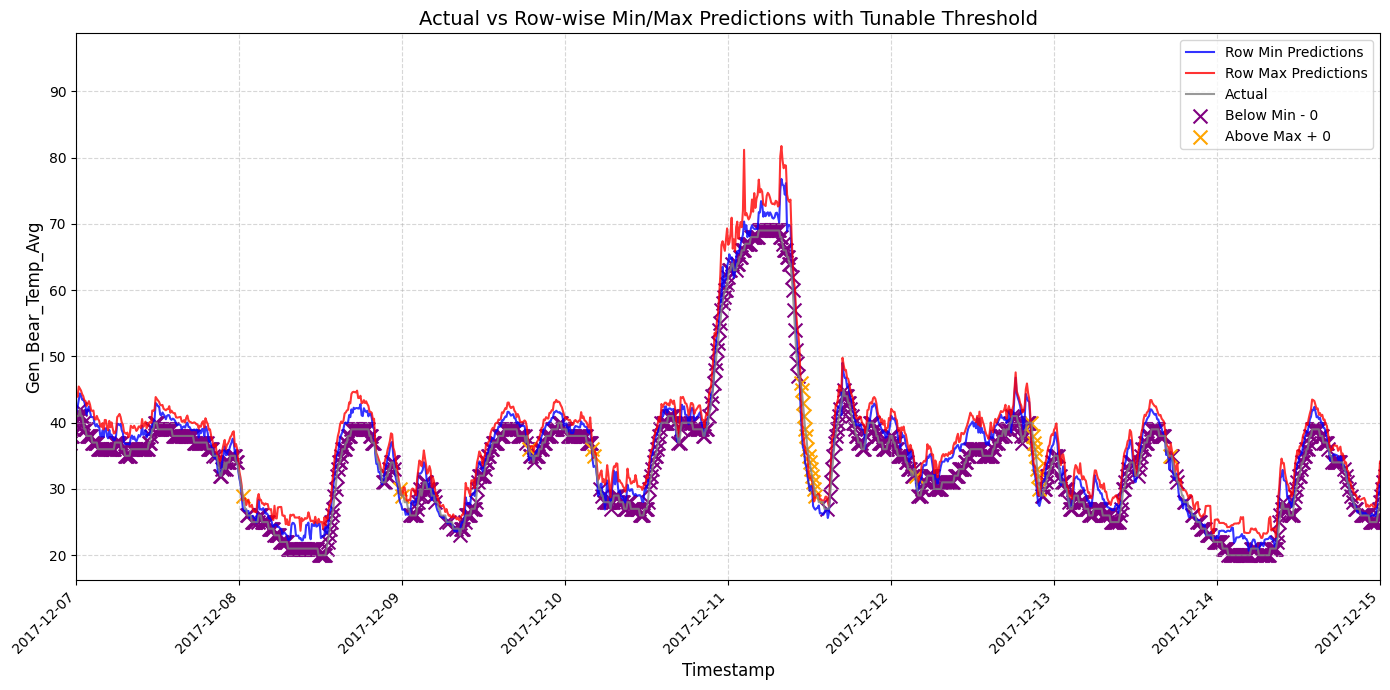

In [34]:
# Checking other dates of the year when the turbine generator is in healthy condition:

import matplotlib.pyplot as plt
import pandas as pd

# Ensure Timestamp column is in datetime format
merged_df_filtered17_sorted["Timestamp"] = pd.to_datetime(merged_df_filtered17_sorted["Timestamp"])

# Sort the DataFrame by Timestamp
merged_df_filtered17_sorted = merged_df_filtered17_sorted.sort_values(by="Timestamp")

# Define tunable threshold
threshold = 0  # Change this value as needed (e.g., 2 means >2 above max or <-2 below min)

# Identify prediction columns
prediction_columns = [col for col in merged_df_filtered17_sorted.columns if col.startswith('pred_comb_')]

# Ensure prediction columns are numeric
merged_df_filtered17_sorted[prediction_columns] = merged_df_filtered17_sorted[prediction_columns].apply(pd.to_numeric, errors='coerce')

# Compute row-wise min and max for prediction columns
merged_df_filtered17_sorted["row_min"] = merged_df_filtered17_sorted[prediction_columns].min(axis=1)
merged_df_filtered17_sorted["row_max"] = merged_df_filtered17_sorted[prediction_columns].max(axis=1)

# Flag where actual values are outside the row-wise min and max with a threshold
merged_df_filtered17_sorted["below_min"] = (
    merged_df_filtered17_sorted[target_column] < (merged_df_filtered17_sorted["row_min"] - threshold)
).astype(int)
merged_df_filtered17_sorted["above_max"] = (
    merged_df_filtered17_sorted[target_column] > (merged_df_filtered17_sorted["row_max"] + threshold)
).astype(int)

# Plot
plt.figure(figsize=(14, 7))

# Line plot for row-wise minimum predictions
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted["row_min"], 
    color='blue', alpha=0.8, label='Row Min Predictions', linewidth=1.5
)

# Line plot for row-wise maximum predictions
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted["row_max"], 
    color='red', alpha=0.8, label='Row Max Predictions', linewidth=1.5
)

# Line plot for actual values
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted[target_column],  
    color='grey', alpha=0.8, label='Actual', linestyle='-', linewidth=1.5
)

# Scatter points where actual is below row_min - threshold
plt.scatter(
    merged_df_filtered17_sorted["Timestamp"][merged_df_filtered17_sorted["below_min"] == 1],
    merged_df_filtered17_sorted[target_column][merged_df_filtered17_sorted["below_min"] == 1],
    color='purple', marker='x', s=100, label=f'Below Min - {threshold}'
)

# Scatter points where actual is above row_max + threshold
plt.scatter(
    merged_df_filtered17_sorted["Timestamp"][merged_df_filtered17_sorted["above_max"] == 1],
    merged_df_filtered17_sorted[target_column][merged_df_filtered17_sorted["above_max"] == 1],
    color='orange', marker='x', s=100, label=f'Above Max + {threshold}'
)

# Highlight x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Define interval for x-axis (adjust as needed)
plt.xlim(pd.to_datetime('2017-12-07'), pd.to_datetime('2017-12-15'))

# Title and labels
plt.title("Actual vs Row-wise Min/Max Predictions with Tunable Threshold", fontsize=14)
plt.xlabel("Timestamp", fontsize=12)
plt.ylabel(target_column, fontsize=12)

# Legend and grid for clarity
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()


In [37]:
merged_df["Gen_Bear_Temp_Avg"].max()

90

In [41]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
lower_limit = 10  # Operational lower limit for the turbine
upper_limit = 100  # Hard maximum limit for temperatures
consecutive_steps = 5  # Number of consecutive steps within normal range to stop recording
max_length = 20  # Maximum allowed length of recorded sequence

# Initialize anomaly flag
merged_df_filtered17_sorted["anomaly_flag"] = 0  # New column to mark anomalies

# Loop through the data
for i in range(len(merged_df_filtered17_sorted)):
    # Check if the actual temperature exceeds the row_max
    if merged_df_filtered17_sorted.loc[i, "Gen_Bear_Temp_Avg"] > merged_df_filtered17_sorted.loc[i, "row_max"]:
        temp_list = []  # To store the sequence of temperatures
        start_idx = i  # Start index of the loop
        
        # Start recording temperatures
        while i < len(merged_df_filtered17_sorted):
            current_temp = merged_df_filtered17_sorted.loc[i, "Gen_Bear_Temp_Avg"]
            
            # Add current temperature to the list
            temp_list.append(current_temp)
            
            # Break if temperatures return to normal for consecutive_steps
            if all(
                merged_df_filtered17_sorted.loc[i - j, "Gen_Bear_Temp_Avg"] <= merged_df_filtered17_sorted.loc[i - j, "row_max"]
                for j in range(consecutive_steps)
            ):
                break
            
            # Break if the list length exceeds the max length
            if len(temp_list) > max_length:
                break
            
            i += 1
        
        # Analyze the recorded list
        # a. Remove values outside operational limits
        temp_list = [t for t in temp_list if lower_limit <= t <= upper_limit]
        
        # b. Check if the average is positive
        average_positive = np.mean(temp_list) > 0
        
        # c. Check for a positive slope
        if len(temp_list) > 1:  # Ensure there are at least 2 points
            slope_positive = np.polyfit(range(len(temp_list)), temp_list, 1)[0] > 0
        else:
            slope_positive = False
        
        # Mark anomaly if all conditions are met
        if average_positive and slope_positive:
            merged_df_filtered17_sorted.loc[start_idx:i, "anomaly_flag"] = 1  # Mark anomaly for the range

# Plot the anomalies
plt.figure(figsize=(14, 7))

# Plot actual temperature
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted["Gen_Bear_Temp_Avg"], 
    label="Actual Temperature (Gen_Bear_Temp_Avg)", color="grey", alpha=0.8
)

# Highlight anomalies
anomaly_points = merged_df_filtered17_sorted[merged_df_filtered17_sorted["anomaly_flag"] == 1]
plt.scatter(
    anomaly_points["Timestamp"], 
    anomaly_points["Gen_Bear_Temp_Avg"], 
    color="red", marker="o", s=50, label="Anomalies"
)

# Plot row-wise min and max predictions
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted["row_min"], 
    label="Row Min Predictions", color="blue"
)
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted["row_max"], 
    label="Row Max Predictions", color="red"
)

# Labels and legend
plt.xlabel("Timestamp")
plt.ylabel("Temperature (Gen_Bear_Temp_Avg)")
plt.title("Anomaly Detection Based on Exceeding Row Max")
plt.legend()
plt.grid(alpha=0.5)
plt.show()


KeyError: 0

In [42]:
merged_df_filtered17_sorted

Turbine_ID                 Timestamp  Gen_RPM_Max  Gen_RPM_Min  \
87615        T07 2017-01-01 00:00:00+00:00       1513.4       1255.3   
37433        T07 2017-01-01 00:10:00+00:00       1485.4       1243.1   
54937        T07 2017-01-01 00:20:00+00:00       1505.3       1255.1   
87608        T07 2017-01-01 00:30:00+00:00       1486.6       1246.1   
19102        T07 2017-01-01 00:40:00+00:00       1381.6       1241.4   
...          ...                       ...          ...          ...   
729          T07 2017-12-31 23:10:00+00:00       1576.2       1253.8   
734          T07 2017-12-31 23:20:00+00:00       1577.7       1231.2   
29823        T07 2017-12-31 23:30:00+00:00       1282.8       1232.5   
738          T07 2017-12-31 23:40:00+00:00       1269.8       1230.8   
65839        T07 2017-12-31 23:50:00+00:00       1329.9       1193.0   

       Gen_RPM_Avg  Gen_RPM_Std  Gen_Bear_Temp_Avg  Gen_Phase1_Temp_Avg  \
87615       1336.5         47.6               36.0                   58   
37433       1307.9         34.7               36.0                   58   
54937       1325.9         41.4               36.0                   58   
87608       1322.4         44.7               36.0                   58   
19102       1292.4         31.1               36.0                   58   
...            ...          ...                ...                  ...   
729         1387.4         79.7               39.0                   64   
734         1343.0         87.5               39.0                   63   
29823       1250.7          8.5               38.0                   63   
738         1250.2          6.9               38.0                   62   
65839       1257.6         18.9               38.0                   61   

       Gen_Phase2_Temp_Avg  Gen_Phase3_Temp_Avg  ...  \
87615                   58                   58  ...   
37433                   58                   58  ...   
54937                   58                   58  ...   
87608                   58                   58  ...   
19102                   58                   58  ...   
...                    ...                  ...  ...   
729                     64                   63  ...   
734                     63                   63  ...   
29823                   63                   62  ...   
738                     62                   61  ...   
65839                   61                   61  ...   

       combination_28_prediction  combination_29_prediction  \
87615                  46.956501                  47.429569   
37433                  46.956501                  47.429569   
54937                  47.188297                  47.113556   
87608                  47.188297                  47.113556   
19102                  47.188297                  47.113556   
...                          ...                        ...   
729                    55.677704                  54.490917   
734                    55.677704                  54.490917   
29823                  56.287609                  55.119858   
738                    56.287609                  55.119858   
65839                  54.925369                  53.860775   

       combination_30_prediction  combination_31_prediction  \
87615                  46.956501                  47.429569   
37433                  46.956501                  47.429569   
54937                  47.188297                  47.113556   
87608                  47.188297                  47.113556   
19102                  47.188297                  47.113556   
...                          ...                        ...   
729                    55.677704                  54.490917   
734                    55.677704                  54.490917   
29823                  56.287609                  55.119858   
738                    56.287609                  55.119858   
65839                  54.925369                  53.860775   

       combination_32_prediction    row_min    row_ma

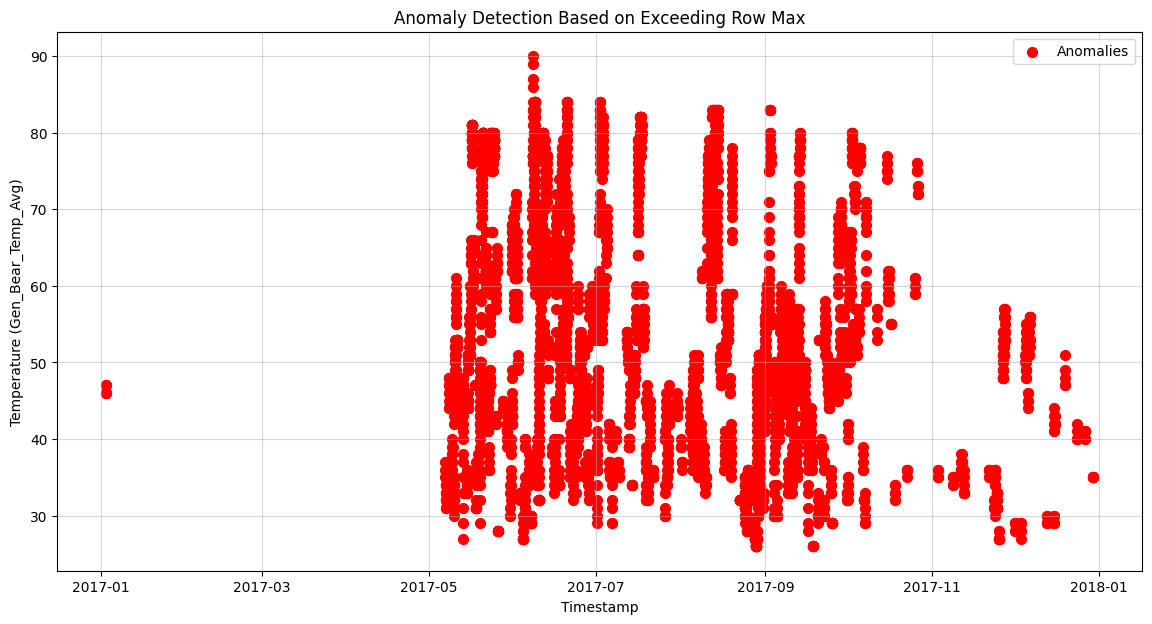

In [45]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
lower_limit = 10  # Operational lower limit for the turbine
upper_limit = 100  # Hard maximum limit for temperatures
consecutive_steps = 5  # Number of consecutive steps within normal range to stop recording
max_length = 200  # Maximum allowed length of recorded sequence

# Initialize anomaly flag
merged_df_filtered17_sorted["anomaly_flag"] = 0  # New column to mark anomalies

# Loop through the data
for i in range(len(merged_df_filtered17_sorted)):
    # Access row data using .iloc to ensure proper indexing
    if merged_df_filtered17_sorted.iloc[i]["Gen_Bear_Temp_Avg"] > merged_df_filtered17_sorted.iloc[i]["row_max"]:
        temp_list = []  # To store the sequence of temperatures
        start_idx = i  # Start index of the loop

        # Start recording temperatures
        while i < len(merged_df_filtered17_sorted):
            current_temp = merged_df_filtered17_sorted.iloc[i]["Gen_Bear_Temp_Avg"]

            # Add current temperature to the list
            temp_list.append(current_temp)

            # Break if temperatures return to normal for consecutive_steps
            if all(
                merged_df_filtered17_sorted.iloc[i - j]["Gen_Bear_Temp_Avg"] <= merged_df_filtered17_sorted.iloc[i - j]["row_max"]
                for j in range(min(consecutive_steps, i + 1))  # Ensure no out-of-bound access
            ):
                break

            # Break if the list length exceeds the max length
            if len(temp_list) > max_length:
                break

            i += 1

        # Analyze the recorded list
        # a. Remove values outside operational limits
        temp_list = [t for t in temp_list if lower_limit <= t <= upper_limit]

        # b. Check if the average is positive
        average_positive = np.mean(temp_list) > 0

        # c. Check for a positive slope
        if len(temp_list) > 1:  # Ensure there are at least 2 points
            slope_positive = np.polyfit(range(len(temp_list)), temp_list, 1)[0] > 0
        else:
            slope_positive = False

        # Mark anomaly if all conditions are met
        if average_positive and slope_positive:
            merged_df_filtered17_sorted.loc[
                merged_df_filtered17_sorted.index[start_idx:i], "anomaly_flag"
            ] = 1  # Mark anomaly for the range

# Plot the anomalies
plt.figure(figsize=(14, 7))

# Plot actual temperature
"""plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted["Gen_Bear_Temp_Avg"], 
    label="Actual Temperature (Gen_Bear_Temp_Avg)", color="grey", alpha=0.8
)"""

# Highlight anomalies
anomaly_points = merged_df_filtered17_sorted[merged_df_filtered17_sorted["anomaly_flag"] == 1]
plt.scatter(
    anomaly_points["Timestamp"], 
    anomaly_points["Gen_Bear_Temp_Avg"], 
    color="red", marker="o", s=50, label="Anomalies"
)

# Plot row-wise min and max predictions
"""plt.scatter(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted["row_min"], 
    label="Row Min Predictions", color="blue"
)"""
"""plt.scatter(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted["row_max"], 
    label="Row Max Predictions", color="red"
)"""

# Labels and legend
plt.xlabel("Timestamp")
plt.ylabel("Temperature (Gen_Bear_Temp_Avg)")
plt.title("Anomaly Detection Based on Exceeding Row Max")
plt.legend()
plt.grid(alpha=0.5)
plt.show()


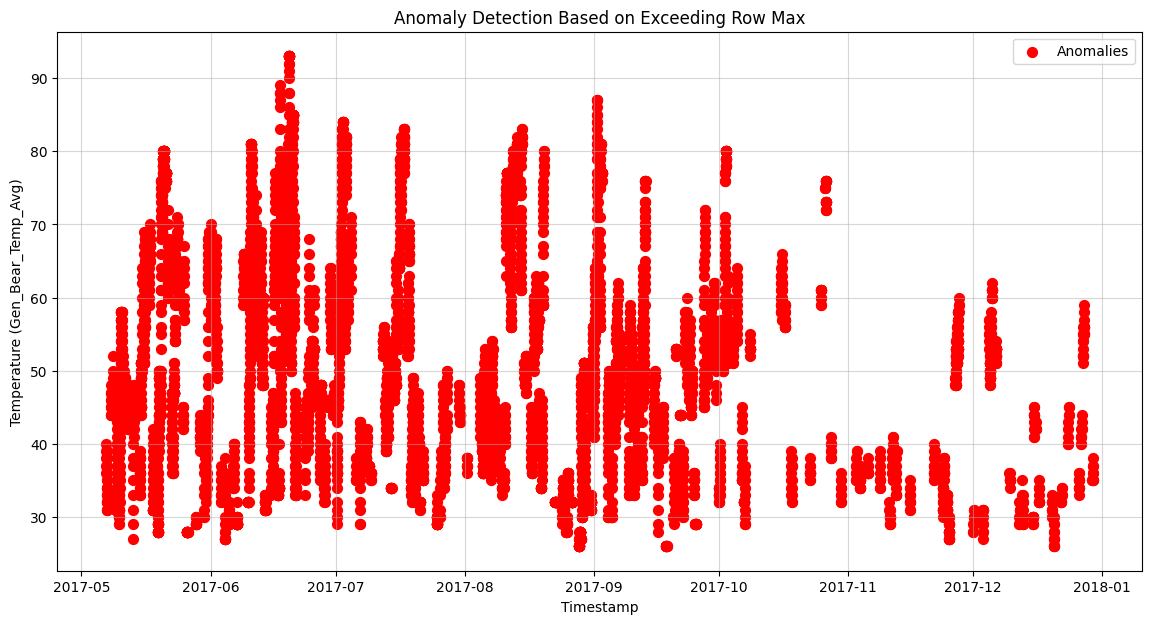

In [46]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
lower_limit = 10  # Operational lower limit for the turbine
upper_limit = 100  # Hard maximum limit for temperatures
consecutive_steps = 10  # Number of consecutive steps within normal range to stop recording
max_length = 250  # Maximum allowed length of recorded sequence

# Compute the difference between actual temperature and row_max
merged_df_filtered17_sorted["difference"] = (
    merged_df_filtered17_sorted["Gen_Bear_Temp_Avg"] - merged_df_filtered17_sorted["row_max"]
)

# Initialize anomaly flag
merged_df_filtered17_sorted["anomaly_flag"] = 0  # New column to mark anomalies

# Loop through the data
for i in range(len(merged_df_filtered17_sorted)):
    # Start recording the sequence if the difference is positive
    if merged_df_filtered17_sorted.iloc[i]["difference"] > 0:
        temp_list = []  # To store the sequence of temperatures
        start_idx = i  # Start index of the loop

        # Start recording temperatures
        while i < len(merged_df_filtered17_sorted):
            current_temp = merged_df_filtered17_sorted.iloc[i]["Gen_Bear_Temp_Avg"]

            # Add current temperature to the list
            temp_list.append(current_temp)

            # Check if temperatures return to normal for consecutive_steps
            if all(
                merged_df_filtered17_sorted.iloc[i - j]["difference"] <= 0
                for j in range(min(consecutive_steps, i + 1))  # Ensure no out-of-bound access
            ):
                break

            # Break if the list length exceeds the max length
            if len(temp_list) > max_length:
                break

            i += 1

        # Analyze the recorded list
        # a. Remove values outside operational limits
        temp_list = [t for t in temp_list if lower_limit <= t <= upper_limit]

        # b. Check if the average is positive
        average_positive = np.mean(temp_list) > 0

        # c. Check for a positive slope
        if len(temp_list) > 1:  # Ensure there are at least 2 points
            slope_positive = np.polyfit(range(len(temp_list)), temp_list, 1)[0] > 0
        else:
            slope_positive = False

        # Mark anomaly if all conditions are met
        if average_positive and slope_positive:
            merged_df_filtered17_sorted.loc[
                merged_df_filtered17_sorted.index[start_idx:i], "anomaly_flag"
            ] = 1  # Mark anomaly for the range

# Plot the anomalies
plt.figure(figsize=(14, 7))

"""# Plot actual temperature
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted["Gen_Bear_Temp_Avg"], 
    label="Actual Temperature (Gen_Bear_Temp_Avg)", color="grey", alpha=0.8
)"""

# Highlight anomalies
anomaly_points = merged_df_filtered17_sorted[merged_df_filtered17_sorted["anomaly_flag"] == 1]
plt.scatter(
    anomaly_points["Timestamp"], 
    anomaly_points["Gen_Bear_Temp_Avg"], 
    color="red", marker="o", s=50, label="Anomalies"
)

"""# Plot row-wise min and max predictions
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted["row_min"], 
    label="Row Min Predictions", color="blue"
)
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted["row_max"], 
    label="Row Max Predictions", color="red"
)"""

# Labels and legend
plt.xlabel("Timestamp")
plt.ylabel("Temperature (Gen_Bear_Temp_Avg)")
plt.title("Anomaly Detection Based on Exceeding Row Max")
plt.legend()
plt.grid(alpha=0.5)
plt.show()


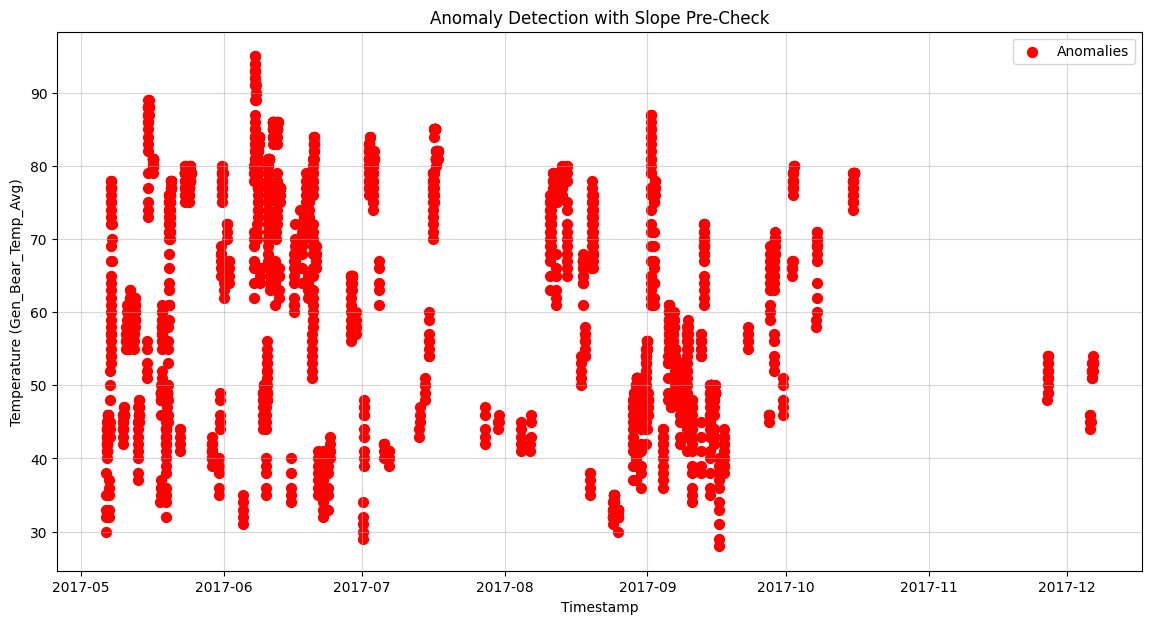

In [47]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
lower_limit = 10  # Operational lower limit for the turbine
upper_limit = 100  # Hard maximum limit for temperatures
consecutive_steps = 5  # Number of consecutive steps within normal range to stop recording
max_length = 20  # Maximum allowed length of recorded sequence
check_slope_window = 3  # Number of rows (Z) to check slope before starting

# Compute the difference between actual temperature and row_max
merged_df_filtered17_sorted["difference"] = (
    merged_df_filtered17_sorted["Gen_Bear_Temp_Avg"] - merged_df_filtered17_sorted["row_max"]
)

# Initialize anomaly flag
merged_df_filtered17_sorted["anomaly_flag"] = 0  # New column to mark anomalies

# Loop through the data
for i in range(len(merged_df_filtered17_sorted)):
    # Ensure there are enough rows to calculate the initial slope
    if i >= check_slope_window:
        # Extract the last Z rows to check the slope
        recent_temps = merged_df_filtered17_sorted.iloc[i - check_slope_window : i]["Gen_Bear_Temp_Avg"].values
        slope = np.polyfit(range(check_slope_window), recent_temps, 1)[0]  # Calculate the slope

        # Only proceed if the slope is positive
        if slope > 0:
            # Start recording the sequence if the difference is positive
            if merged_df_filtered17_sorted.iloc[i]["difference"] > 0:
                temp_list = []  # To store the sequence of temperatures
                start_idx = i  # Start index of the loop

                # Start recording temperatures
                while i < len(merged_df_filtered17_sorted):
                    current_temp = merged_df_filtered17_sorted.iloc[i]["Gen_Bear_Temp_Avg"]

                    # Add current temperature to the list
                    temp_list.append(current_temp)

                    # Check for a positive slope in the list
                    if len(temp_list) > 1:  # Ensure there are at least 2 points for slope calculation
                        ongoing_slope = np.polyfit(range(len(temp_list)), temp_list, 1)[0]  # Calculate ongoing slope
                        if ongoing_slope <= 0:  # Break if the slope is no longer positive
                            break

                    # Check if temperatures return to normal for consecutive_steps
                    if all(
                        merged_df_filtered17_sorted.iloc[i - j]["difference"] <= 0
                        for j in range(min(consecutive_steps, i + 1))  # Ensure no out-of-bound access
                    ):
                        break

                    # Break if the list length exceeds the max length
                    if len(temp_list) > max_length:
                        break

                    i += 1

                # Analyze the recorded list
                # a. Remove values outside operational limits
                temp_list = [t for t in temp_list if lower_limit <= t <= upper_limit]

                # b. Check if the average is positive
                average_positive = np.mean(temp_list) > 0

                # c. Check for a positive slope
                if len(temp_list) > 1:  # Ensure there are at least 2 points
                    final_slope_positive = np.polyfit(range(len(temp_list)), temp_list, 1)[0] > 0
                else:
                    final_slope_positive = False

                # Mark anomaly if all conditions are met
                if average_positive and final_slope_positive:
                    merged_df_filtered17_sorted.loc[
                        merged_df_filtered17_sorted.index[start_idx:i], "anomaly_flag"
                    ] = 1  # Mark anomaly for the range

# Plot the anomalies
plt.figure(figsize=(14, 7))

# Plot actual temperature
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted["Gen_Bear_Temp_Avg"], 
    label="Actual Temperature (Gen_Bear_Temp_Avg)", color="grey", alpha=0.8
)

# Highlight anomalies
anomaly_points = merged_df_filtered17_sorted[merged_df_filtered17_sorted["anomaly_flag"] == 1]
plt.scatter(
    anomaly_points["Timestamp"], 
    anomaly_points["Gen_Bear_Temp_Avg"], 
    color="red", marker="o", s=50, label="Anomalies"
)

""# Plot row-wise min and max predictions
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted["row_min"], 
    label="Row Min Predictions", color="blue"
)
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted["row_max"], 
    label="Row Max Predictions", color="red"
)""

# Labels and legend
plt.xlabel("Timestamp")
plt.ylabel("Temperature (Gen_Bear_Temp_Avg)")
plt.title("Anomaly Detection with Slope Pre-Check")
plt.legend()
plt.grid(alpha=0.5)
plt.show()


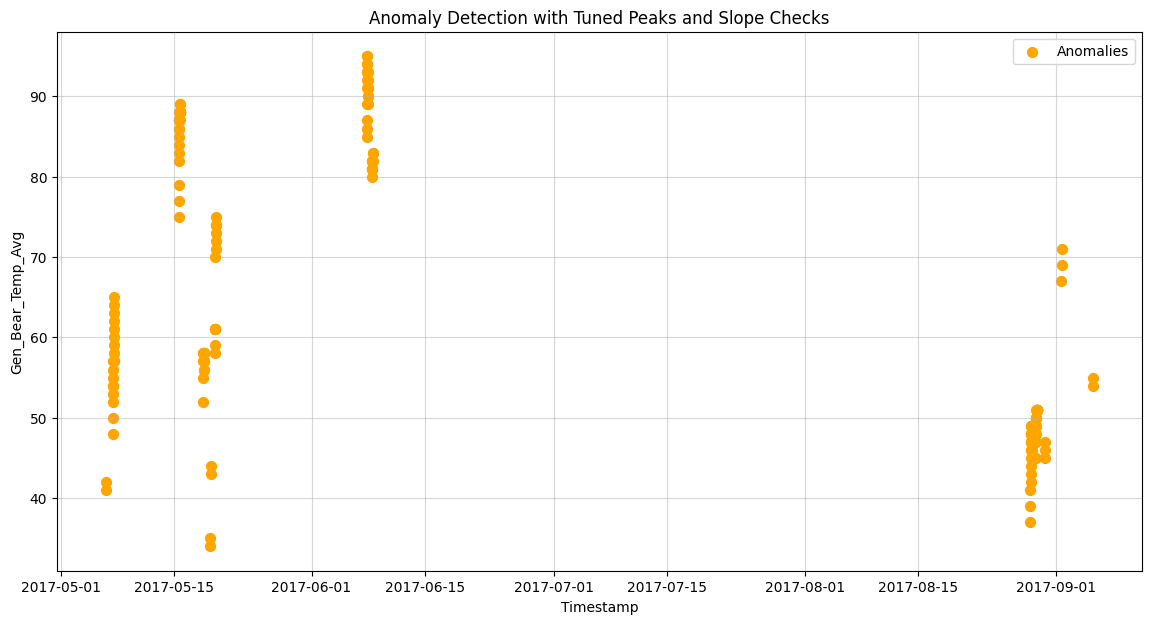

In [50]:
# Parameters
buffer = 3  # Additional buffer above row_max to consider as a high point
check_slope_window = 5  # Number of rows (Z) to check slope before initiating anomalies
consecutive_steps = 3  # Number of positive slope steps to confirm peak anomalies
max_length = 20  # Maximum sequence length for anomalies
lower_limit = 10  # Lower operational limit
upper_limit = 100  # Upper operational limit

# Calculate the difference from row_max
merged_df_filtered17_sorted["difference"] = (
    merged_df_filtered17_sorted["Gen_Bear_Temp_Avg"] - (merged_df_filtered17_sorted["row_max"] + buffer)
)

# Initialize anomaly flag
merged_df_filtered17_sorted["anomaly_flag"] = 0  # New column for marking anomalies

# Loop through the data
for i in range(len(merged_df_filtered17_sorted)):
    if i >= check_slope_window:
        # Check slope in the last Z rows
        recent_temps = merged_df_filtered17_sorted.iloc[i - check_slope_window : i]["Gen_Bear_Temp_Avg"].values
        slope = np.polyfit(range(check_slope_window), recent_temps, 1)[0]  # Fit linear slope

        # Proceed only if slope is positive
        if slope > 0:
            # Start anomaly detection if current difference > 0
            if merged_df_filtered17_sorted.iloc[i]["difference"] > 0:
                temp_list = []
                start_idx = i

                # Begin sequence recording
                while i < len(merged_df_filtered17_sorted):
                    current_temp = merged_df_filtered17_sorted.iloc[i]["Gen_Bear_Temp_Avg"]
                    temp_list.append(current_temp)

                    # Check ongoing slope
                    if len(temp_list) > 1:
                        ongoing_slope = np.polyfit(range(len(temp_list)), temp_list, 1)[0]
                        if ongoing_slope <= 0:
                            break

                    # Validate sequence with buffer and slope
                    if (
                        merged_df_filtered17_sorted.iloc[i]["difference"] <= 0
                        or len(temp_list) > max_length
                    ):
                        break

                    i += 1

                # Final anomaly validation
                if len(temp_list) >= consecutive_steps:
                    avg_temp = np.mean(temp_list)
                    final_slope = np.polyfit(range(len(temp_list)), temp_list, 1)[0]
                    if avg_temp > lower_limit and avg_temp < upper_limit and final_slope > 0:
                        merged_df_filtered17_sorted.loc[
                            merged_df_filtered17_sorted.index[start_idx:i], "anomaly_flag"
                        ] = 1

# Visualization
plt.figure(figsize=(14, 7))
"""plt.plot(
    merged_df_filtered17_sorted["Timestamp"],
    merged_df_filtered17_sorted["Gen_Bear_Temp_Avg"],
    label="Actual Temperature (Gen_Bear_Temp_Avg)",
    color="grey",
    alpha=0.8,
)"""
"""plt.plot(
    merged_df_filtered17_sorted["Timestamp"],
    merged_df_filtered17_sorted["row_max"],
    label="Row Max + Buffer",
    color="red",
)"""
anomalies = merged_df_filtered17_sorted[merged_df_filtered17_sorted["anomaly_flag"] == 1]
plt.scatter(
    anomalies["Timestamp"],
    anomalies["Gen_Bear_Temp_Avg"],
    color="orange",
    label="Anomalies",
    s=50,
)
plt.legend()
plt.title("Anomaly Detection with Tuned Peaks and Slope Checks")
plt.xlabel("Timestamp")
plt.ylabel("Gen_Bear_Temp_Avg")
plt.grid(alpha=0.5)
plt.show()


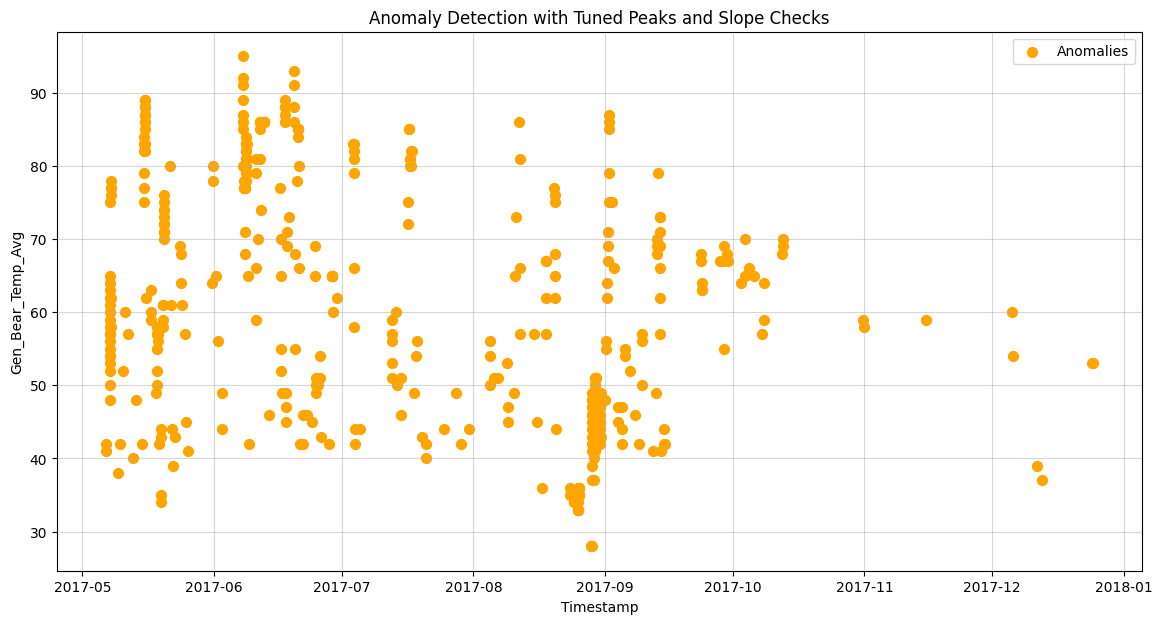

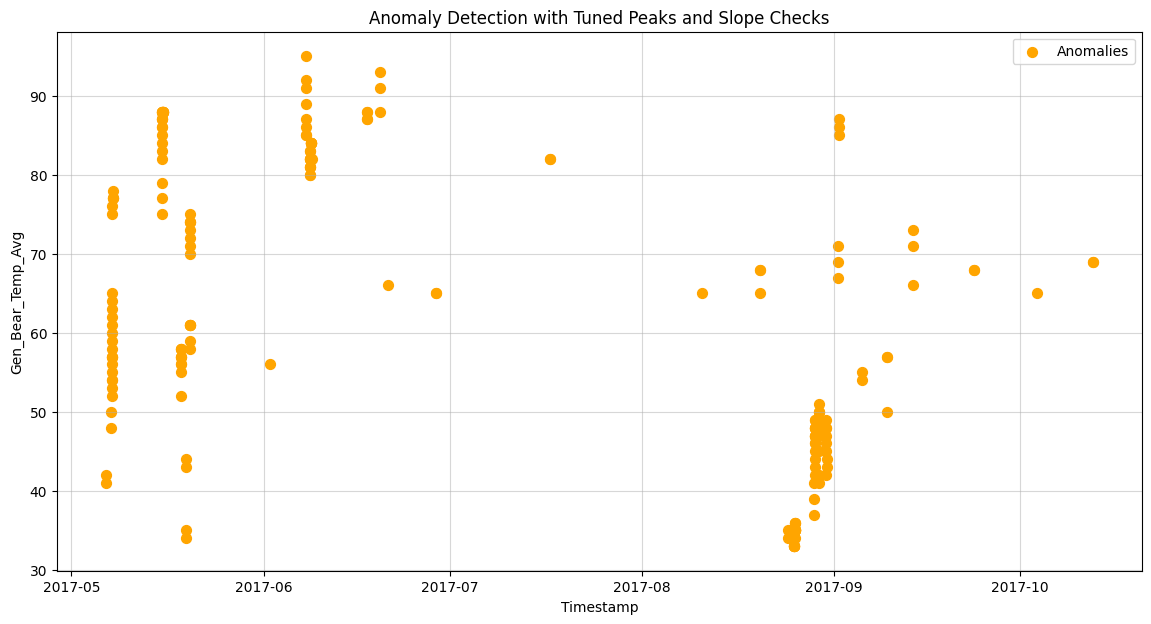

In [161]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Parameters
buffer = 3  # Additional buffer above row_max to consider as a high point
check_slope_window = 1  # Number of rows (Z) to check slope before initiating anomalies
consecutive_steps = 1  # Number of positive slope steps to confirm peak anomalies
max_length = 2 # Maximum sequence length for anomalies
lower_limit = 10  # Lower operational limit
upper_limit = 100  # Upper operational limit

# Flags to control slope dependency checks
check_slope = False  # Set to False to deactivate slope checks (checks the initial slope of Z)
check_ongoing_slope = False  # Set to False to deactivate ongoing slope checks (cancels if an ongoing negative slope is detected)
final_slope_check = False  # Set to False to deactivate final slope check throw (checks if there are only negative slopes and throws away the anomaly if it is only negative)
final_overall_slope_check = True  # Set to True to enable final overall slope check (throws away anomaly if the overall slope is negative)
max_consecutive_negative_slopes = 1  # Max consecutive negative slopes before discarding anomaly

# Calculate the difference from row_max
merged_df_filtered17_sorted["difference"] = (
    merged_df_filtered17_sorted["Gen_Bear_Temp_Avg"] - (merged_df_filtered17_sorted["row_max"] + buffer)
)

# Initialize anomaly flag
merged_df_filtered17_sorted["anomaly_flag"] = 0  # New column for marking anomalies

# Loop through the data
for i in range(len(merged_df_filtered17_sorted)):
    if i >= check_slope_window:
        # Check slope in the last Z rows if slope checks are enabled
        if check_slope:
            recent_temps = merged_df_filtered17_sorted.iloc[i - check_slope_window : i]["Gen_Bear_Temp_Avg"].values
            slope = np.polyfit(range(check_slope_window), recent_temps, 1)[0]  # Fit linear slope

            # Proceed only if slope is positive
            if slope <= 0:
                continue  # Skip this row if slope is non-positive
        
        # Start anomaly detection if current difference > 0
        if merged_df_filtered17_sorted.iloc[i]["difference"] > 0:
            temp_list = []
            start_idx = i
            slopes_between_points = []  # List to store slopes between points
            consecutive_negative_slopes = 0  # Counter for consecutive negative slopes

            # Begin sequence recording
            while i < len(merged_df_filtered17_sorted):
                current_temp = merged_df_filtered17_sorted.iloc[i]["Gen_Bear_Temp_Avg"]
                temp_list.append(current_temp)

                # Check ongoing slope if enabled
                if len(temp_list) > 1 and check_ongoing_slope:
                    ongoing_slope = np.polyfit(range(len(temp_list)), temp_list, 1)[0]
                    if ongoing_slope <= 0:
                        break  # Break if slope is not positive

                # Validate sequence with buffer and slope
                if (
                    merged_df_filtered17_sorted.iloc[i]["difference"] <= 0
                    or len(temp_list) > max_length
                ):
                    break

                # Store slope between consecutive points if there are enough points
                if len(temp_list) > 1:
                    slope_between_points = np.polyfit(range(len(temp_list)), temp_list, 1)[0]
                    slopes_between_points.append(slope_between_points)

                    # Count consecutive negative slopes
                    if slope_between_points <= 0:
                        consecutive_negative_slopes += 1
                    else:
                        consecutive_negative_slopes = 0  # Reset counter if positive slope is found

                i += 1

            # Final anomaly validation with slope check if enabled
            if len(temp_list) >= consecutive_steps:
                avg_temp = np.mean(temp_list)

                # If the final slope check is enabled, check if consecutive negative slopes exceed threshold
                if final_slope_check and consecutive_negative_slopes >= max_consecutive_negative_slopes:
                    continue  # Discard if too many consecutive negative slopes

                # Final overall slope check (if enabled)
                if final_overall_slope_check:
                    overall_slope = np.polyfit(range(len(temp_list)), temp_list, 1)[0]
                    if overall_slope <= 0:
                        continue  # Discard anomaly if overall slope is negative

                # Validate anomaly with temperature and slope conditions
                if avg_temp > lower_limit and avg_temp < upper_limit:
                    merged_df_filtered17_sorted.loc[
                        merged_df_filtered17_sorted.index[start_idx:i], "anomaly_flag"
                    ] = 1

# Visualization
plt.figure(figsize=(14, 7))

# Scatter anomalies
anomalies = merged_df_filtered17_sorted[merged_df_filtered17_sorted["anomaly_flag"] == 1]
plt.scatter(
    anomalies["Timestamp"],
    anomalies["Gen_Bear_Temp_Avg"],
    color="orange",
    label="Anomalies",
    s=50,
)

plt.legend()
plt.title("Anomaly Detection with Tuned Peaks and Slope Checks")
plt.xlabel("Timestamp")
plt.ylabel("Gen_Bear_Temp_Avg")
plt.grid(alpha=0.5)
plt.show()

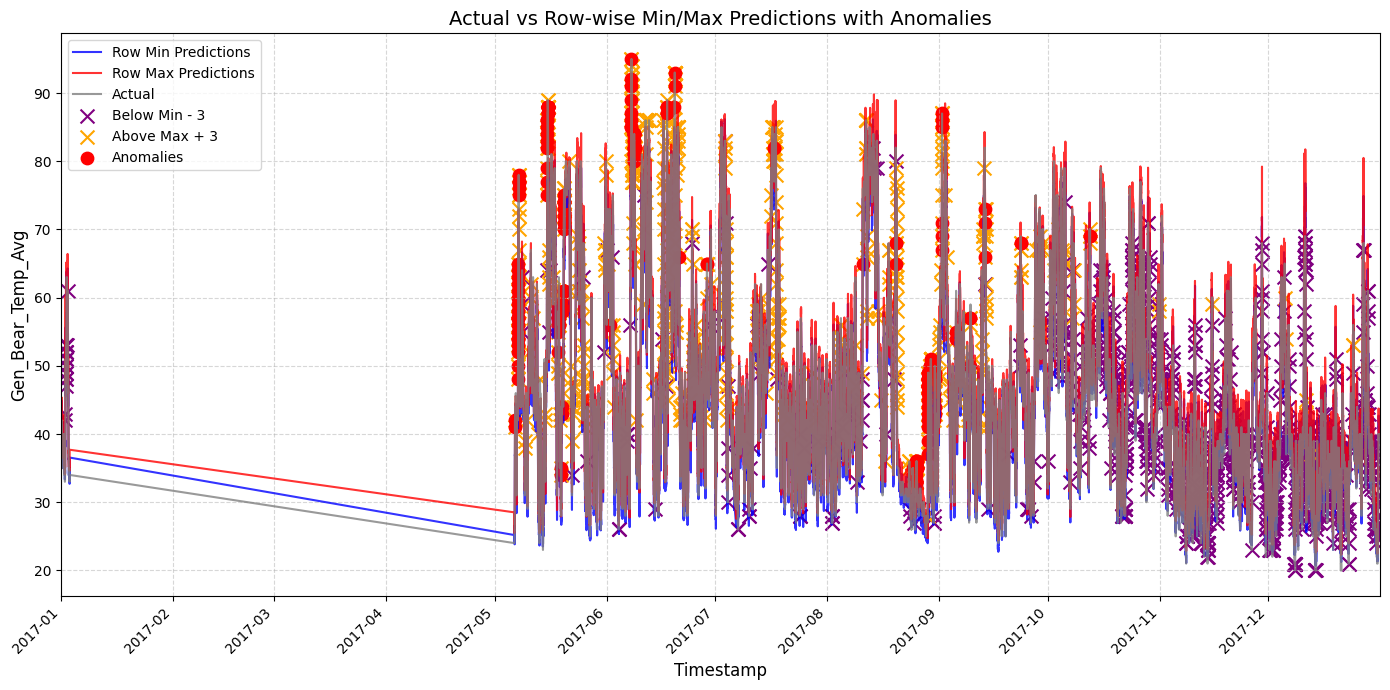

In [162]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure Timestamp column is in datetime format
merged_df_filtered17_sorted["Timestamp"] = pd.to_datetime(merged_df_filtered17_sorted["Timestamp"])

# Sort the DataFrame by Timestamp
merged_df_filtered17_sorted = merged_df_filtered17_sorted.sort_values(by="Timestamp")

# Define tunable threshold
threshold = 3  # Change this value as needed (e.g., 2 means >2 above max or <-2 below min)

# Identify prediction columns
prediction_columns = [col for col in merged_df_filtered17_sorted.columns if col.startswith('pred_comb_')]

# Ensure prediction columns are numeric
merged_df_filtered17_sorted[prediction_columns] = merged_df_filtered17_sorted[prediction_columns].apply(pd.to_numeric, errors='coerce')

# Compute row-wise min and max for prediction columns
merged_df_filtered17_sorted["row_min"] = merged_df_filtered17_sorted[prediction_columns].min(axis=1)
merged_df_filtered17_sorted["row_max"] = merged_df_filtered17_sorted[prediction_columns].max(axis=1)

# Flag where actual values are outside the row-wise min and max with a threshold
merged_df_filtered17_sorted["below_min"] = (
    merged_df_filtered17_sorted["Gen_Bear_Temp_Avg"] < (merged_df_filtered17_sorted["row_min"] - threshold)
).astype(int)
merged_df_filtered17_sorted["above_max"] = (
    merged_df_filtered17_sorted["Gen_Bear_Temp_Avg"] > (merged_df_filtered17_sorted["row_max"] + threshold)
).astype(int)

# Plot
plt.figure(figsize=(14, 7))

# Line plot for row-wise minimum predictions
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted["row_min"], 
    color='blue', alpha=0.8, label='Row Min Predictions', linewidth=1.5
)

# Line plot for row-wise maximum predictions
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted["row_max"], 
    color='red', alpha=0.8, label='Row Max Predictions', linewidth=1.5
)

# Line plot for actual values
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted["Gen_Bear_Temp_Avg"],  
    color='grey', alpha=0.8, label='Actual', linestyle='-', linewidth=1.5
)

# Scatter points where actual is below row_min - threshold
plt.scatter(
    merged_df_filtered17_sorted["Timestamp"][merged_df_filtered17_sorted["below_min"] == 1],
    merged_df_filtered17_sorted["Gen_Bear_Temp_Avg"][merged_df_filtered17_sorted["below_min"] == 1],
    color='purple', marker='x', s=100, label=f'Below Min - {threshold}'
)

# Scatter points where actual is above row_max + threshold
plt.scatter(
    merged_df_filtered17_sorted["Timestamp"][merged_df_filtered17_sorted["above_max"] == 1],
    merged_df_filtered17_sorted["Gen_Bear_Temp_Avg"][merged_df_filtered17_sorted["above_max"] == 1],
    color='orange', marker='x', s=100, label=f'Above Max + {threshold}'
)

# Highlight anomalies (from the anomaly detection step you have)
anomalies = merged_df_filtered17_sorted[merged_df_filtered17_sorted["anomaly_flag"] == 1]
plt.scatter(
    anomalies["Timestamp"],
    anomalies["Gen_Bear_Temp_Avg"],
    color="red",  # Anomalies in red
    label="Anomalies",
    s=80,
    marker='o'  # Circle marker for anomalies
)

# Highlight x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Define interval for x-axis (adjust as needed)
plt.xlim(merged_df_filtered17_sorted["Timestamp"].min(), merged_df_filtered17_sorted["Timestamp"].max())

# Title and labels
plt.title("Actual vs Row-wise Min/Max Predictions with Anomalies", fontsize=14)
plt.xlabel("Timestamp", fontsize=12)
plt.ylabel("Gen_Bear_Temp_Avg", fontsize=12)

# Legend and grid for clarity
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()


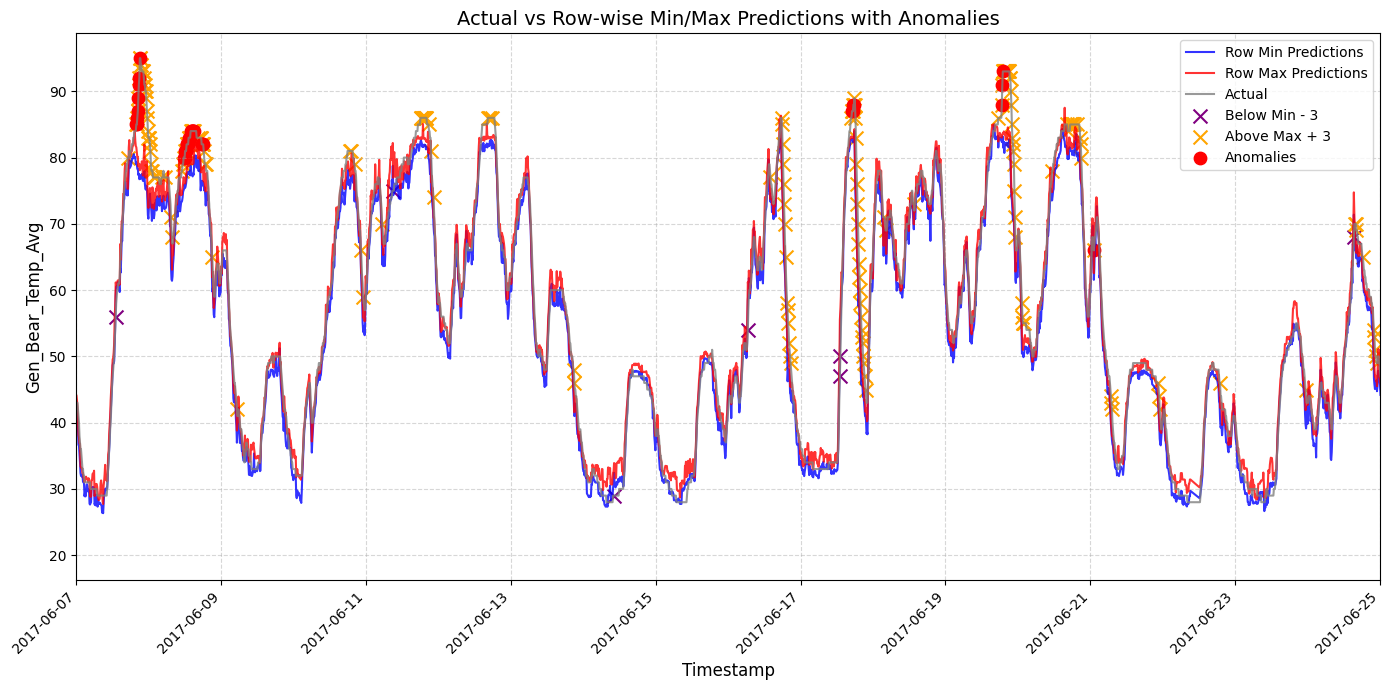

In [163]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure Timestamp column is in datetime format
merged_df_filtered17_sorted["Timestamp"] = pd.to_datetime(merged_df_filtered17_sorted["Timestamp"])

# Sort the DataFrame by Timestamp
merged_df_filtered17_sorted = merged_df_filtered17_sorted.sort_values(by="Timestamp")

# Define tunable threshold
threshold = 3  # Change this value as needed (e.g., 2 means >2 above max or <-2 below min)

# Identify prediction columns
prediction_columns = [col for col in merged_df_filtered17_sorted.columns if col.startswith('pred_comb_')]

# Ensure prediction columns are numeric
merged_df_filtered17_sorted[prediction_columns] = merged_df_filtered17_sorted[prediction_columns].apply(pd.to_numeric, errors='coerce')

# Compute row-wise min and max for prediction columns
merged_df_filtered17_sorted["row_min"] = merged_df_filtered17_sorted[prediction_columns].min(axis=1)
merged_df_filtered17_sorted["row_max"] = merged_df_filtered17_sorted[prediction_columns].max(axis=1)

# Flag where actual values are outside the row-wise min and max with a threshold
merged_df_filtered17_sorted["below_min"] = (
    merged_df_filtered17_sorted["Gen_Bear_Temp_Avg"] < (merged_df_filtered17_sorted["row_min"] - threshold)
).astype(int)
merged_df_filtered17_sorted["above_max"] = (
    merged_df_filtered17_sorted["Gen_Bear_Temp_Avg"] > (merged_df_filtered17_sorted["row_max"] + threshold)
).astype(int)

# Plot
plt.figure(figsize=(14, 7))

# Line plot for row-wise minimum predictions
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted["row_min"], 
    color='blue', alpha=0.8, label='Row Min Predictions', linewidth=1.5
)

# Line plot for row-wise maximum predictions
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted["row_max"], 
    color='red', alpha=0.8, label='Row Max Predictions', linewidth=1.5
)

# Line plot for actual values
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted["Gen_Bear_Temp_Avg"],  
    color='grey', alpha=0.8, label='Actual', linestyle='-', linewidth=1.5
)

# Scatter points where actual is below row_min - threshold
plt.scatter(
    merged_df_filtered17_sorted["Timestamp"][merged_df_filtered17_sorted["below_min"] == 1],
    merged_df_filtered17_sorted["Gen_Bear_Temp_Avg"][merged_df_filtered17_sorted["below_min"] == 1],
    color='purple', marker='x', s=100, label=f'Below Min - {threshold}'
)

# Scatter points where actual is above row_max + threshold
plt.scatter(
    merged_df_filtered17_sorted["Timestamp"][merged_df_filtered17_sorted["above_max"] == 1],
    merged_df_filtered17_sorted["Gen_Bear_Temp_Avg"][merged_df_filtered17_sorted["above_max"] == 1],
    color='orange', marker='x', s=100, label=f'Above Max + {threshold}'
)

# Highlight anomalies (from the anomaly detection step you have)
anomalies = merged_df_filtered17_sorted[merged_df_filtered17_sorted["anomaly_flag"] == 1]
plt.scatter(
    anomalies["Timestamp"],
    anomalies["Gen_Bear_Temp_Avg"],
    color="red",  # Anomalies in red
    label="Anomalies",
    s=80,
    marker='o'  # Circle marker for anomalies
)

# Highlight x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Define interval for x-axis (adjusted for the timeframe from the plot you provided)
plt.xlim(pd.to_datetime('2017-06-07'), pd.to_datetime('2017-06-25'))

# Title and labels
plt.title("Actual vs Row-wise Min/Max Predictions with Anomalies", fontsize=14)
plt.xlabel("Timestamp", fontsize=12)
plt.ylabel("Gen_Bear_Temp_Avg", fontsize=12)

# Legend and grid for clarity
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()


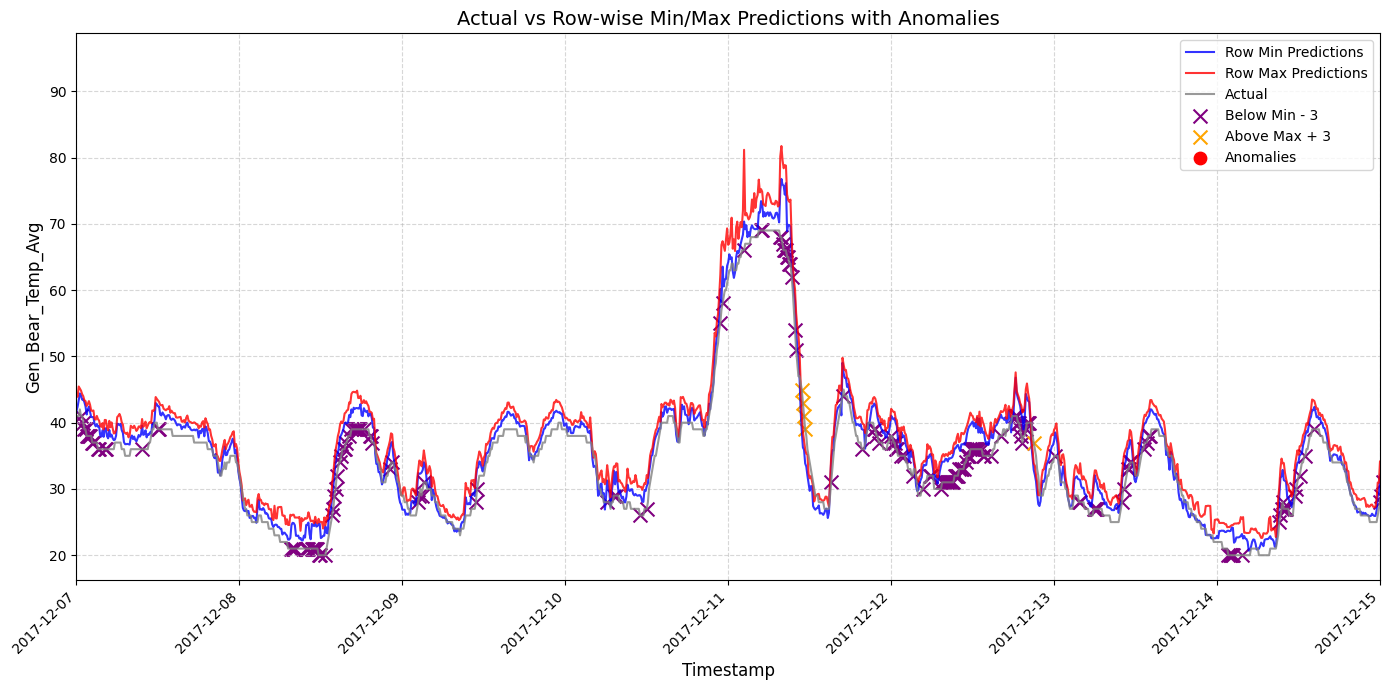

In [164]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure Timestamp column is in datetime format
merged_df_filtered17_sorted["Timestamp"] = pd.to_datetime(merged_df_filtered17_sorted["Timestamp"])

# Sort the DataFrame by Timestamp
merged_df_filtered17_sorted = merged_df_filtered17_sorted.sort_values(by="Timestamp")

# Define tunable threshold
threshold = 3  # Change this value as needed (e.g., 2 means >2 above max or <-2 below min)

# Identify prediction columns
prediction_columns = [col for col in merged_df_filtered17_sorted.columns if col.startswith('pred_comb_')]

# Ensure prediction columns are numeric
merged_df_filtered17_sorted[prediction_columns] = merged_df_filtered17_sorted[prediction_columns].apply(pd.to_numeric, errors='coerce')

# Compute row-wise min and max for prediction columns
merged_df_filtered17_sorted["row_min"] = merged_df_filtered17_sorted[prediction_columns].min(axis=1)
merged_df_filtered17_sorted["row_max"] = merged_df_filtered17_sorted[prediction_columns].max(axis=1)

# Flag where actual values are outside the row-wise min and max with a threshold
merged_df_filtered17_sorted["below_min"] = (
    merged_df_filtered17_sorted["Gen_Bear_Temp_Avg"] < (merged_df_filtered17_sorted["row_min"] - threshold)
).astype(int)
merged_df_filtered17_sorted["above_max"] = (
    merged_df_filtered17_sorted["Gen_Bear_Temp_Avg"] > (merged_df_filtered17_sorted["row_max"] + threshold)
).astype(int)

# Plot
plt.figure(figsize=(14, 7))

# Line plot for row-wise minimum predictions
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted["row_min"], 
    color='blue', alpha=0.8, label='Row Min Predictions', linewidth=1.5
)

# Line plot for row-wise maximum predictions
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted["row_max"], 
    color='red', alpha=0.8, label='Row Max Predictions', linewidth=1.5
)

# Line plot for actual values
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted["Gen_Bear_Temp_Avg"],  
    color='grey', alpha=0.8, label='Actual', linestyle='-', linewidth=1.5
)

# Scatter points where actual is below row_min - threshold
plt.scatter(
    merged_df_filtered17_sorted["Timestamp"][merged_df_filtered17_sorted["below_min"] == 1],
    merged_df_filtered17_sorted["Gen_Bear_Temp_Avg"][merged_df_filtered17_sorted["below_min"] == 1],
    color='purple', marker='x', s=100, label=f'Below Min - {threshold}'
)

# Scatter points where actual is above row_max + threshold
plt.scatter(
    merged_df_filtered17_sorted["Timestamp"][merged_df_filtered17_sorted["above_max"] == 1],
    merged_df_filtered17_sorted["Gen_Bear_Temp_Avg"][merged_df_filtered17_sorted["above_max"] == 1],
    color='orange', marker='x', s=100, label=f'Above Max + {threshold}'
)

# Highlight anomalies (from the anomaly detection step you have)
anomalies = merged_df_filtered17_sorted[merged_df_filtered17_sorted["anomaly_flag"] == 1]
plt.scatter(
    anomalies["Timestamp"],
    anomalies["Gen_Bear_Temp_Avg"],
    color="red",  # Anomalies in red
    label="Anomalies",
    s=80,
    marker='o'  # Circle marker for anomalies
)

# Highlight x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Define interval for x-axis (adjusted for the timeframe from the plot you provided)
plt.xlim(pd.to_datetime('2017-12-07'), pd.to_datetime('2017-12-15'))

# Title and labels
plt.title("Actual vs Row-wise Min/Max Predictions with Anomalies", fontsize=14)
plt.xlabel("Timestamp", fontsize=12)
plt.ylabel("Gen_Bear_Temp_Avg", fontsize=12)

# Legend and grid for clarity
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()
